## PENDAHULUAN

Notebook ini berisi pembuatan model machine learning yang dapat mendeteksi fraud (fraud detection) pada pengguna platform fintech. Fraud dalam hal ini diartikan sebagai pengguna platform yang melakukan pinjaman produk keuangan, tetapi belum melakukan pembayaran sampai tenggat waktu yang telah ditentukan.

Terdapat 4 dataset yang digunakan:
1. Train: data pengguna untuk training mode
2. Test: data pengguna untuk dilakukan prediksi
3. non_borrower: data pengguna yang jarang melakukan pinjaman sehingga tidak dijadikan target klasifikasi
4. loan_activities: data catatan peminjaman produk keuangan pada platform

## PREPROCESSING

### Import Libraries

In [1]:
#libraries

##preprocessing
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer

import seaborn as sns
import matplotlib.pyplot as plt

#modelling
!pip install imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE #for imbalanced target
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import average_precision_score, classification_report, accuracy_score #evaluation metrics
from sklearn.model_selection import train_test_split #evaluating model performance

!pip install catboost #gradient boosting models, these three usually have the best performance
from xgboost import XGBClassifier
from catboost import CatBoostClassifier,Pool
from lightgbm import LGBMClassifier

!pip install optuna #hyperparameter tuning
import optuna

import pickle #save model


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


ERROR: Invalid requirement: '#gradient'

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\rifqi\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\rifqi\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\rifqi\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeri

### Download Dataset

In [7]:
import os
import logging
!pip install gdown
import gdown
import zipfile

def download_data(url, filename, dir_name: str = "data") -> None:
    if not os.path.isdir(dir_name):
        os.mkdir(dir_name)
    os.chdir(dir_name)
    logging.info("Downloading data....")
    gdown.download(
        url, quiet=False
    )
    logging.info("Extracting zip file....")
    with zipfile.ZipFile(f"{filename}.zip", 'r') as zip_ref:
        zip_ref.extractall(filename)
    os.remove(f"{filename}.zip")
    os.chdir("..")

download_data(url="https://drive.google.com/uc?&id=1joOspf-LvEBdKLw48S2WeBno_l5J1DPj",
              filename="ristek-datathon-2024",
              dir_name="datathon-2024")

Downloading...
From (original): https://drive.google.com/uc?&id=1joOspf-LvEBdKLw48S2WeBno_l5J1DPj
From (redirected): https://drive.google.com/uc?id=1joOspf-LvEBdKLw48S2WeBno_l5J1DPj&confirm=t&uuid=17fe090a-1cb8-4f74-b068-9c408f808a1d
To: C:\Users\FAVIAN\LOMBA\DATATHON\PENYISIHAN\datathon-2024\datathon-2024\datathon-2024\ristek-datathon-2024.zip
100%|███████████████████████████████████████████████████████████████████████████████| 113M/113M [00:45<00:00, 2.47MB/s]


### Import Dataset

In [2]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
loan = pd.read_csv('loan_activities.csv')
nonbw = pd.read_csv('non_borrower_user.csv')

#sorted by timestamp chronological order 
loan = loan.sort_values(by=["user_id", "ts"])

#make a copy
test_prepro = test.copy()
train_prepro = train.copy()

train_prepro.head()

,user_id,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,label
0,3,1.0,1.0,0.275,0.255,0.927273,0.4,0.260,0.040,0.254,0.976923,1.0,0.072727,0.023077,0.078431,0.750000,0.018182,0.250000,0
1,5,0.0,0.0,0.430,0.365,0.848837,0.4,1.253,0.210,1.235,0.985634,1.0,0.151163,0.014366,0.054795,0.500000,0.011628,0.250000,0
2,9,1.0,3.0,1.315,0.825,0.627376,0.9,2.385,0.128,2.270,0.951782,1.0,0.372624,0.048218,0.054545,0.777778,0.003802,0.111111,0
3,10,0.0,5.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.000,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
4,17,1.0,1.0,0.235,0.160,0.680851,0.1,0.120,0.002,0.104,0.866667,0.0,0.319149,0.133333,0.031250,-1.000000,-1.000000,-1.000000,0


### Cek Missing Values

In [3]:
nonbw['user_id'].nunique()

2474949

In [4]:
NA_df = pd.DataFrame(index=['train', 'test','nonbw'], columns=test_prepro.columns)

for col in test_prepro.columns:
    NA_df.loc['train', col] = np.round(train[col].isna().sum() / len(train_prepro) * 100, 3)
    NA_df.loc['test', col] = np.round(test[col].isna().sum() / len(test_prepro) * 100, 3)
    NA_df.loc['nonbw',col] =  np.round(test[col].isna().sum() / len(nonbw) * 100, 3)

NA_df = NA_df.map(lambda x: f"{x}%")

NA_df

AttributeError: 'DataFrame' object has no attribute 'map'

In [5]:
loan.isna().sum()

user_id              0
reference_contact    0
loan_type            0
ts                   0
dtype: int64

## EXPLORATORY DATA ANALYSIS (EDA) 

### Univariate Analysis

In [5]:
train.describe()

,user_id,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,label
count,8.578990e+05,857899.000000,857899.000000,857899.000000,857899.000000,857899.000000,857899.000000,857899.000000,857899.000000,857899.00000,857899.000000,857899.000000,857899.000000,857899.000000,857899.000000,857899.000000,857899.000000,857899.000000,857899.000000
mean,1.851235e+06,0.746870,3.709053,0.545364,0.391718,0.175067,0.315356,0.961431,-0.245161,0.91576,0.251290,1.336002,-0.282764,-0.358987,-0.351351,0.030651,-0.555226,-0.440967,0.012655
std,1.069052e+06,0.439532,1.934880,1.941448,1.766663,0.880198,1.790893,2.766861,0.696857,2.71027,0.932444,3.565165,0.589381,0.522695,0.518399,0.875284,0.503602,0.644649,0.111782
min,3.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,9.251405e+05,0.000000,2.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,1.851614e+06,1.000000,4.000000,0.365000,0.295000,0.738007,0.300000,0.312000,0.011000,0.28700,0.922936,0.000000,0.068966,0.011834,0.029297,0.500000,-1.000000,-1.000000,0.000000
75%,2.778174e+06,1.000000,5.000000,1.150000,0.915000,0.884120,0.900000,1.501000,0.114000,1.43400,0.977522,2.000000,0.187500,0.044816,0.057143,0.800000,0.008230,0.200000,0.000000
max,3.700548e+06,1.000000,8.000000,111.815000,111.475000,1.000000,456.300000,64.119000,12.338000,63.41600,1.000000,1313.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,1.000000


In [6]:
test.describe()

,user_id,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16
count,3.677020e+05,367702.000000,367702.000000,367702.000000,367702.000000,367702.000000,367702.000000,367702.000000,367702.000000,367702.000000,367702.000000,367702.000000,367702.000000,367702.000000,367702.000000,367702.000000,367702.000000,367702.000000
mean,1.846733e+06,0.746082,3.707519,0.548174,0.393795,0.172392,0.317049,0.966813,-0.246681,0.920817,0.248578,1.346014,-0.283819,-0.360005,-0.353226,0.028216,-0.554844,-0.440620
std,1.068780e+06,0.439969,1.935365,1.948030,1.772834,0.880674,1.738704,2.791356,0.699443,2.734626,0.933026,3.514389,0.590000,0.523162,0.518760,0.875934,0.503653,0.644444
min,4.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,9.194445e+05,0.000000,2.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,1.844812e+06,1.000000,4.000000,0.360000,0.290000,0.736264,0.300000,0.309000,0.011000,0.284000,0.922222,0.000000,0.068582,0.011779,0.029091,0.500000,-1.000000,-1.000000
75%,2.773638e+06,1.000000,5.000000,1.150000,0.920000,0.883721,0.900000,1.505000,0.114000,1.437000,0.977305,2.000000,0.187500,0.044960,0.057143,0.800000,0.008230,0.200000
max,3.700544e+06,1.000000,8.000000,90.390000,90.160000,1.000000,120.200000,68.646000,12.679000,68.027000,1.000000,534.000000,1.000000,1.000000,1.000000,2.500000,1.000000,1.000000


In [116]:
nonbw.describe().applymap(lambda x: f"{x:0.3f}")

C:\Users\FAVIAN\AppData\Local\Temp\ipykernel_4076\4138426259.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  nonbw.describe().applymap(lambda x: f"{x:0.3f}")


,user_id,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16
count,2474949.000,2474949.000,2474949.000,2474949.000,2474949.000,2474949.000,2474949.000,2474949.000,2474949.000,2474949.000,2474949.000,2474949.000,2474949.000,2474949.000,2474949.000,2474949.000,2474949.000,2474949.000
mean,1850467.686,0.389,2.764,-0.402,-0.432,-0.316,-0.460,-0.346,-0.644,-0.354,-0.285,0.439,-0.622,-0.654,-0.652,-0.452,-0.798,-0.735
std,1067902.822,0.822,2.869,0.946,0.895,0.903,0.939,1.045,0.522,1.030,0.942,1.568,0.543,0.497,0.502,0.834,0.407,0.544
min,0.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,0.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000
25%,925942.000,0.000,0.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,0.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000
50%,1850605.000,1.000,3.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,0.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000
75%,2774748.000,1.000,5.000,0.250,0.215,0.841,0.200,0.234,0.007,0.220,0.957,0.000,0.059,0.011,0.036,0.571,-1.000,-1.000
max,3700549.000,1.000,8.000,153.510,153.375,1.000,231.200,34.302,7.132,34.064,1.000,456.000,1.000,1.000,1.000,3.000,1.000,1.000


In [9]:
#mengecek variansi tiap features
def var_dfs(test):
    test.drop('user_id',axis=1,inplace=True)
    variance_df = pd.DataFrame(
        index=['train', 'test','nonbw'], 
        columns=test.columns
    )

    for col in test.columns:
        variance_df.loc['train', col] = np.round(train_prepro[col].var(), 3)
        variance_df.loc['test', col] = np.round(test[col].var(), 3)
        variance_df.loc['nonbw', col] = np.round(nonbw[col].var(), 3)
    
    return variance_df

var_dfs(test_prepro)

,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16
train,0.193,3.744,3.769,3.121,0.775,3.207,7.656,0.486,7.346,0.869,12.71,0.347,0.273,0.269,0.766,0.254,0.416
test,0.194,3.746,3.795,3.143,0.776,3.023,7.792,0.489,7.478,0.871,12.351,0.348,0.274,0.269,0.767,0.254,0.415
nonbw,0.676,8.229,0.895,0.802,0.815,0.881,1.093,0.272,1.062,0.887,2.458,0.295,0.247,0.252,0.696,0.166,0.296


Terdapat perbedaan nilai yang cukup jauh antarvariable sehingga perlu dilakukan scaling untuk beberapa variabel nantinya

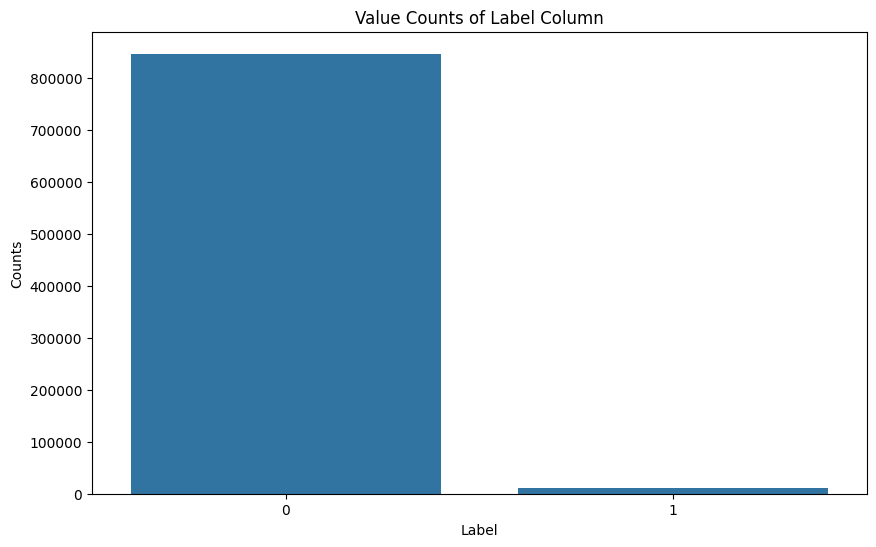

label
0    847042
1     10857
Name: count, dtype: int64

In [88]:
#Cek jumlah kategori pada variabel target
value_counts = train_prepro['label'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=value_counts.index, y=value_counts.values)

plt.title('Value Counts of Label Column')
plt.xlabel('Label')
plt.ylabel('Counts')
plt.show()

value_counts

Label sangat imbalanced, perlu diperhatikan saat modelling nanti

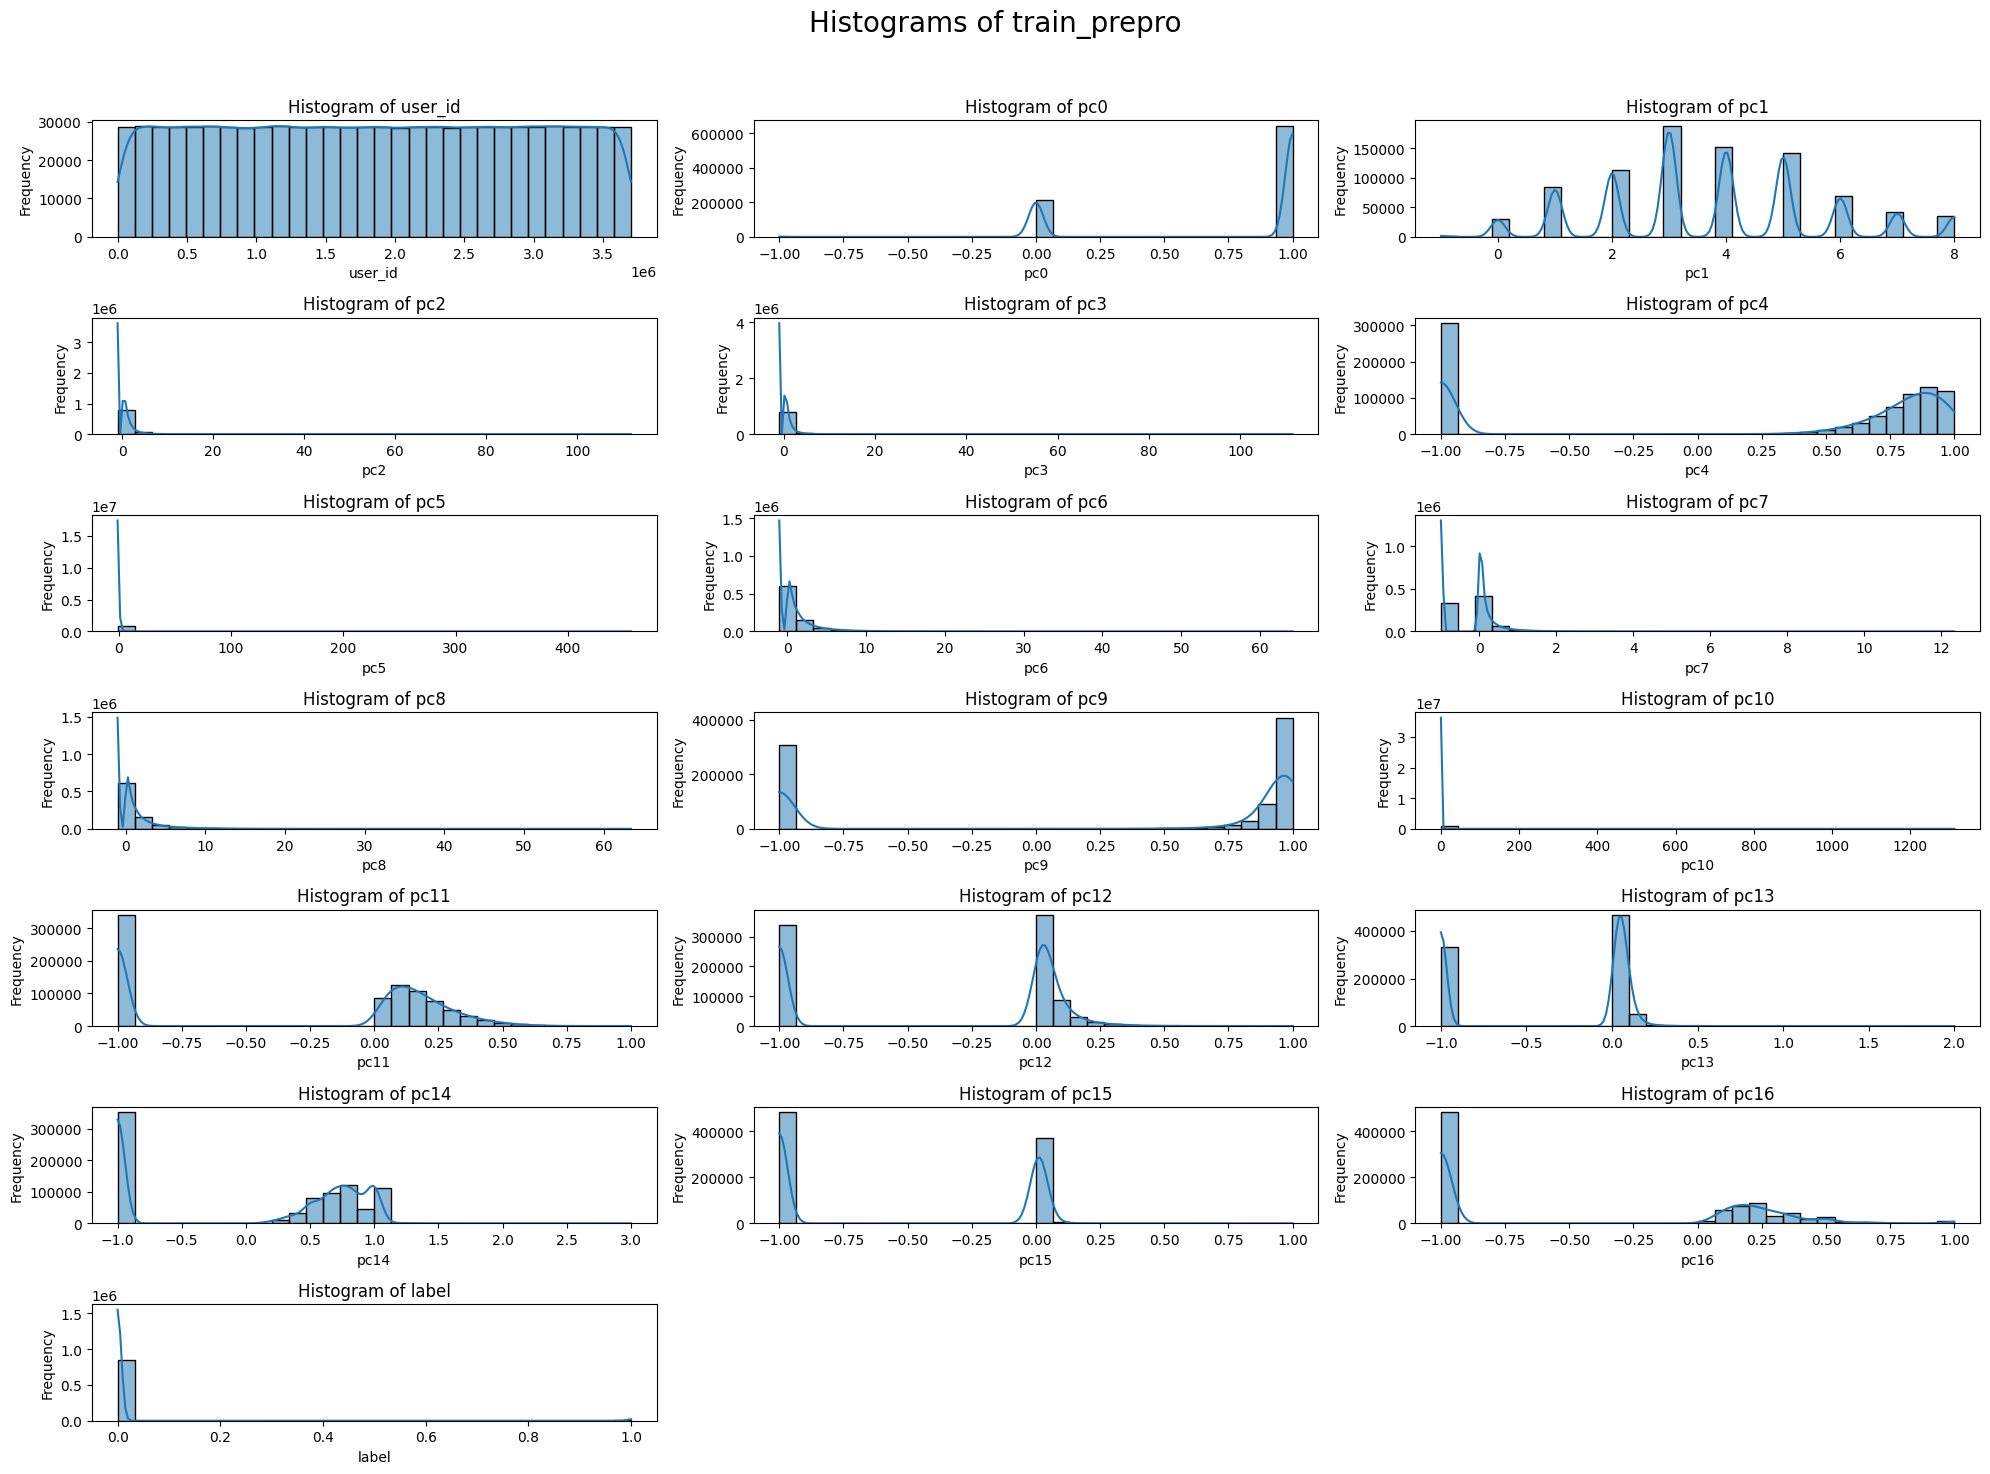

In [118]:
def histograms(df, title):
    num_cols = df.select_dtypes(include='number').columns  # Select only numerical columns
    plt.figure(figsize=(20, 15))  # Adjust figure size as needed

    for i, col in enumerate(num_cols):
        plt.subplot(len(num_cols) // 3 + 1, 3, i + 1)
        sns.histplot(df[col], bins=30, kde=True)
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')

    plt.suptitle(title, fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
    plt.show()

histograms(train_prepro, 'Histograms of train_prepro')

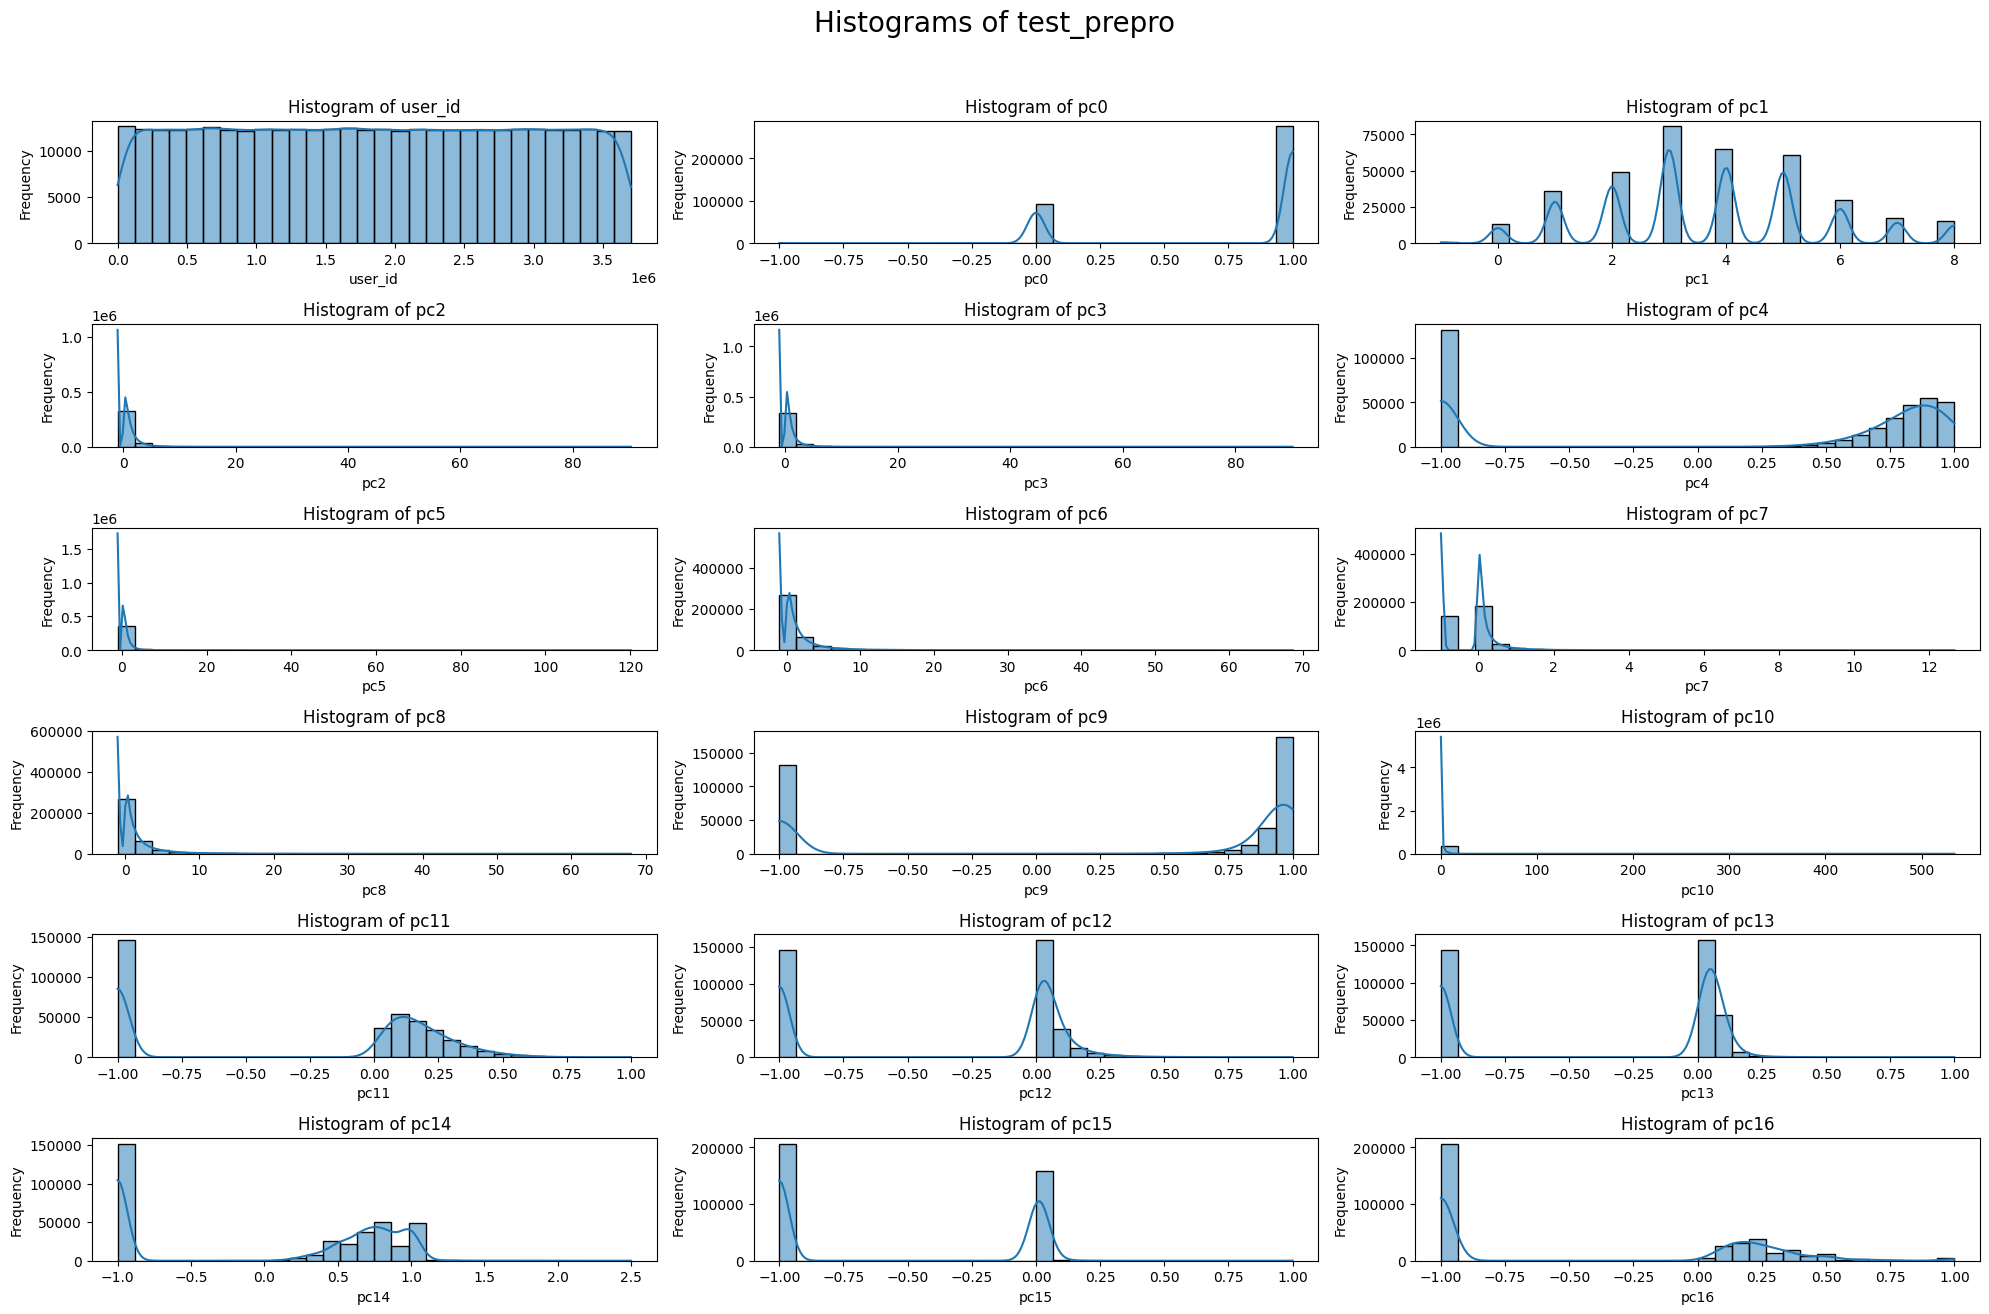

In [119]:
histograms(test_prepro, 'Histograms of test_prepro')

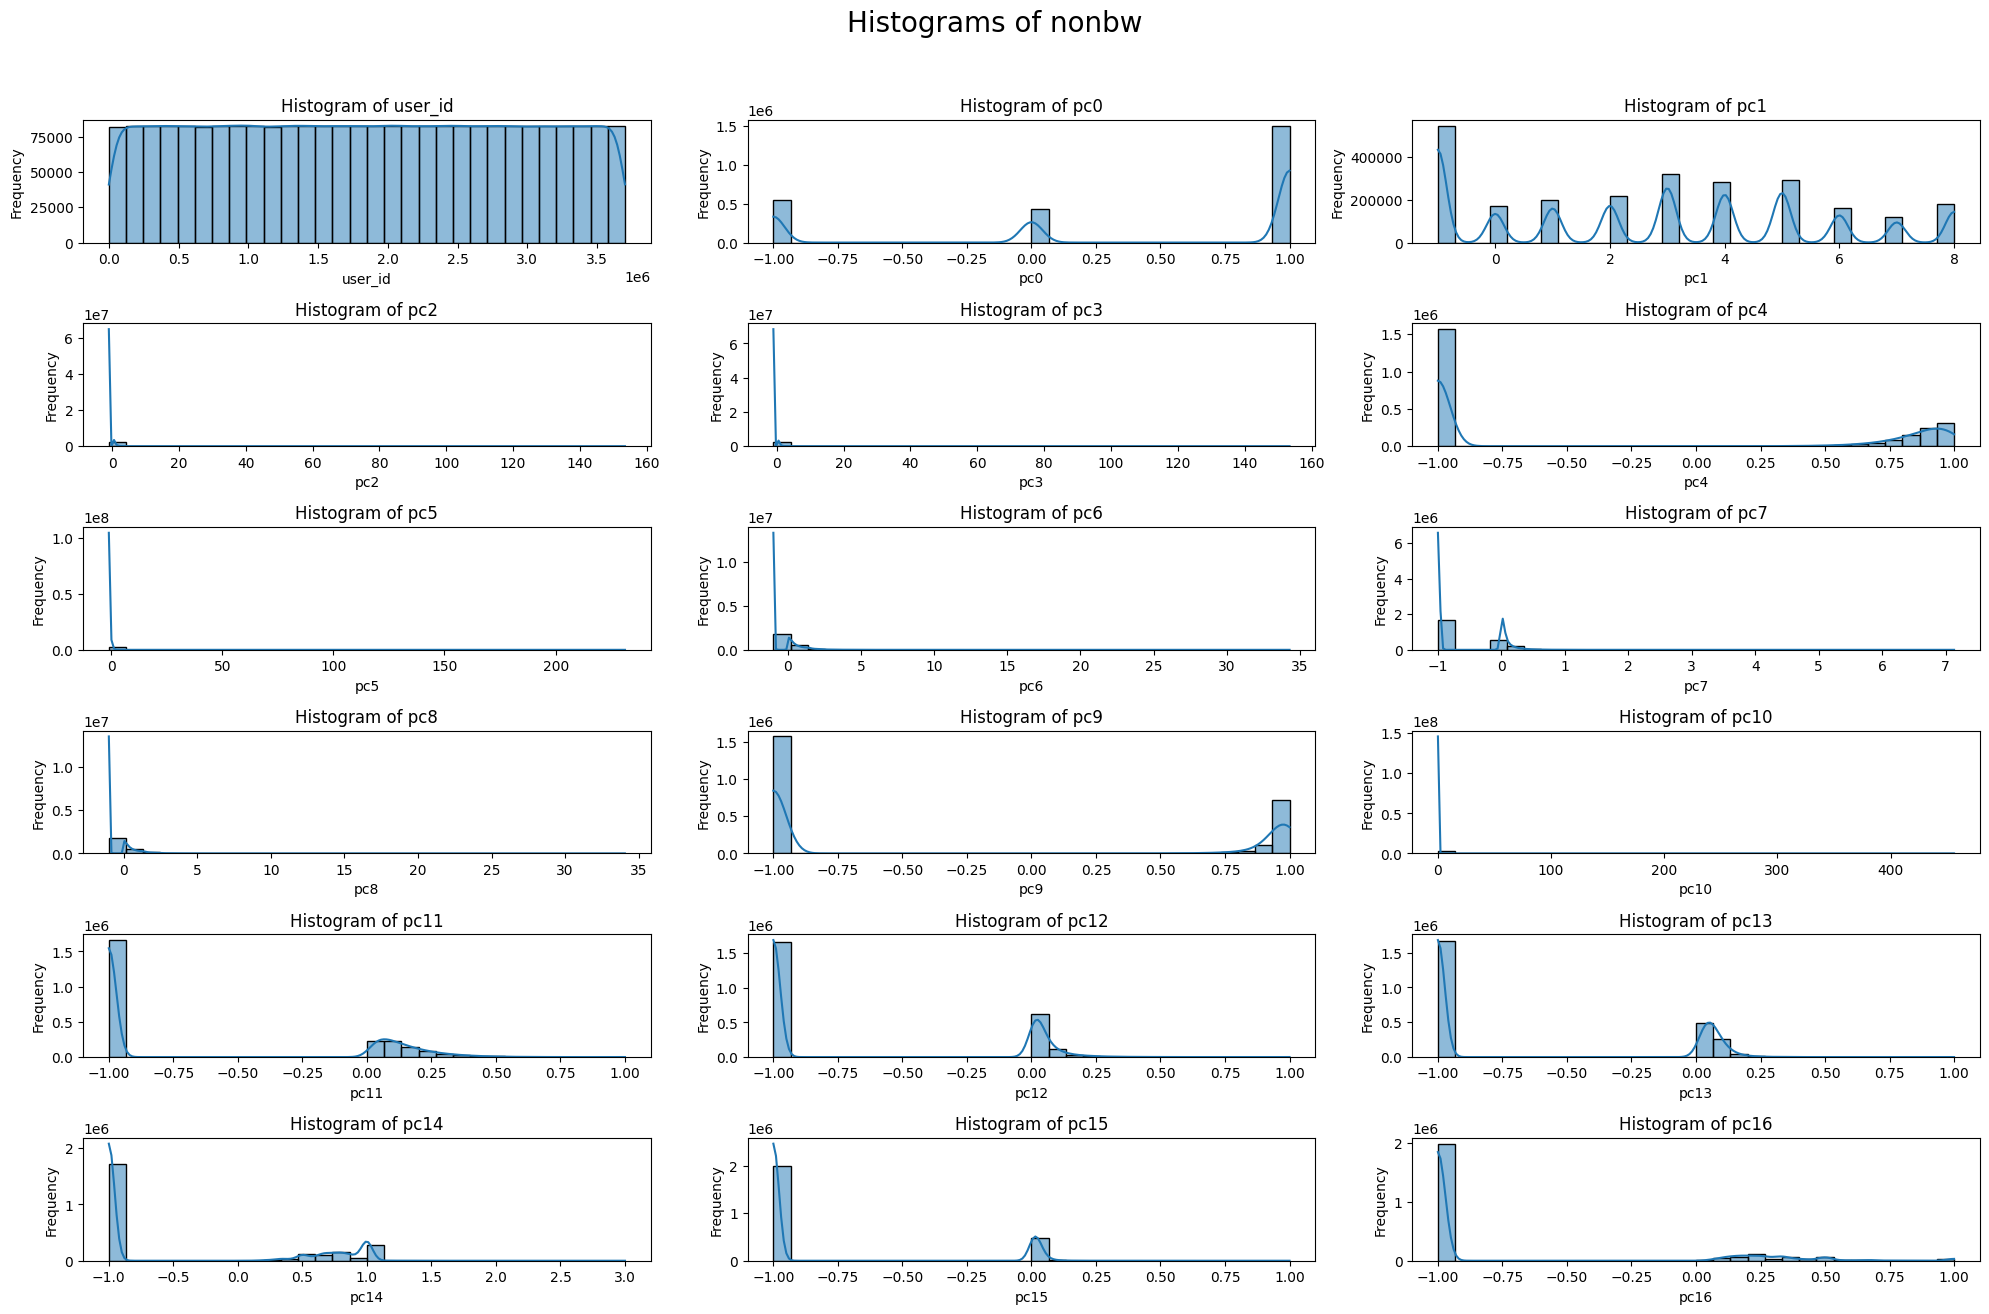

In [120]:
histograms(nonbw, 'Histograms of nonbw')

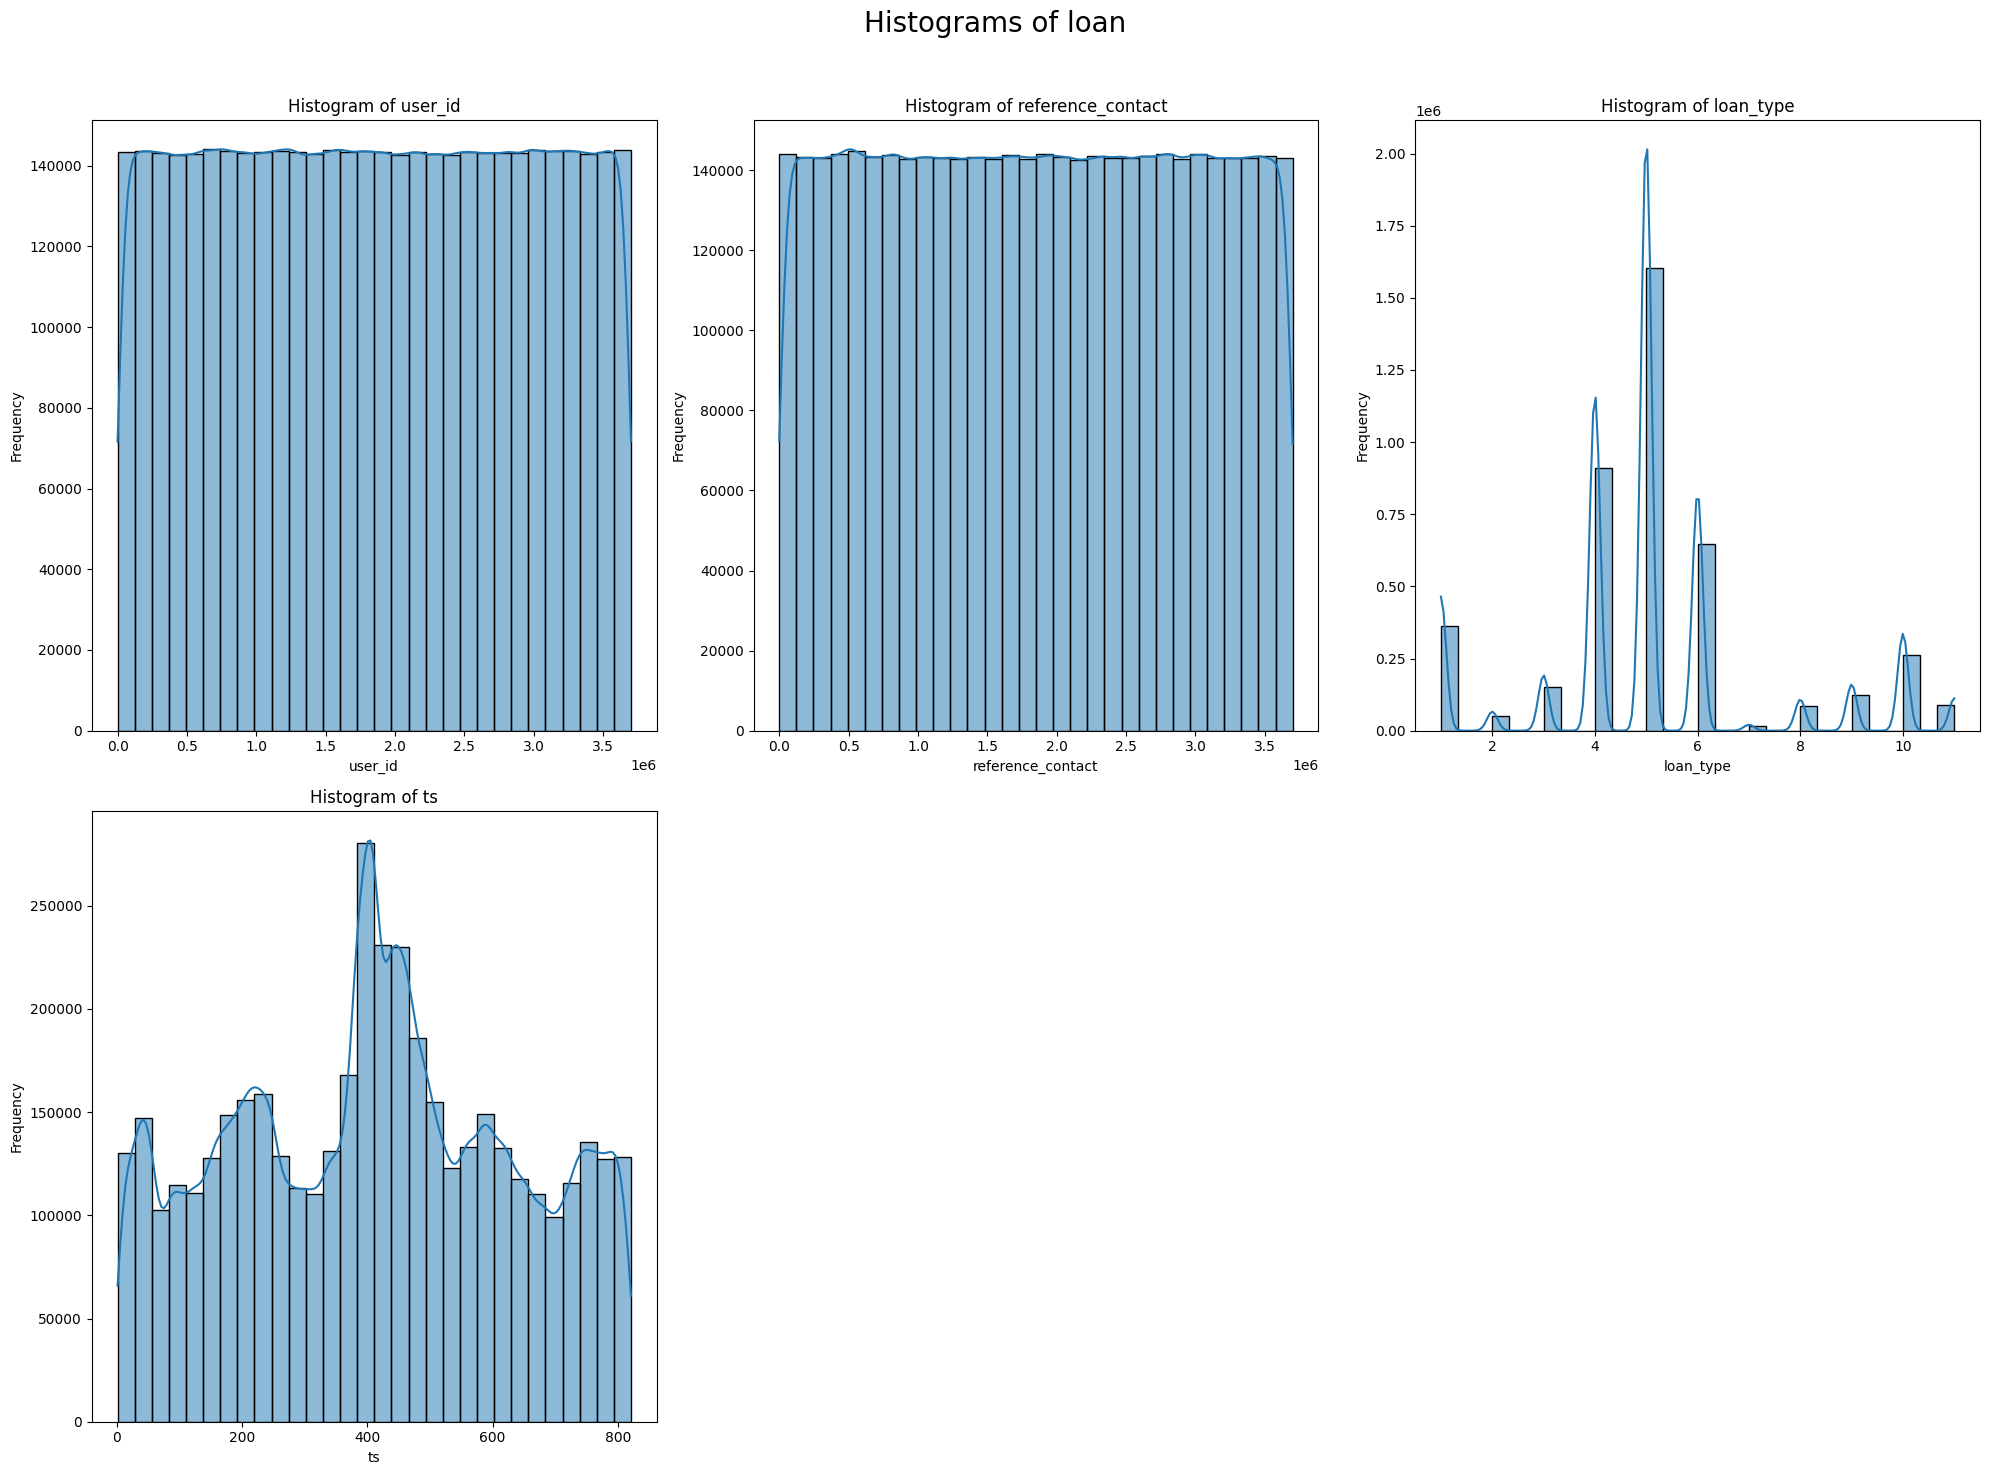

In [12]:
histograms(loan, 'Histograms of loan')

In [13]:
def plot_boxplots(df, title):
    num_cols = df.select_dtypes(include='number').columns 
    plt.figure(figsize=(20, 15))  # Adjust figure size as needed

    for i, col in enumerate(num_cols):
        plt.subplot(len(num_cols) // 3 + 1, 3, i + 1)
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col}')
        plt.xlabel(col)
        plt.ylabel('Value')

    plt.suptitle(title, fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

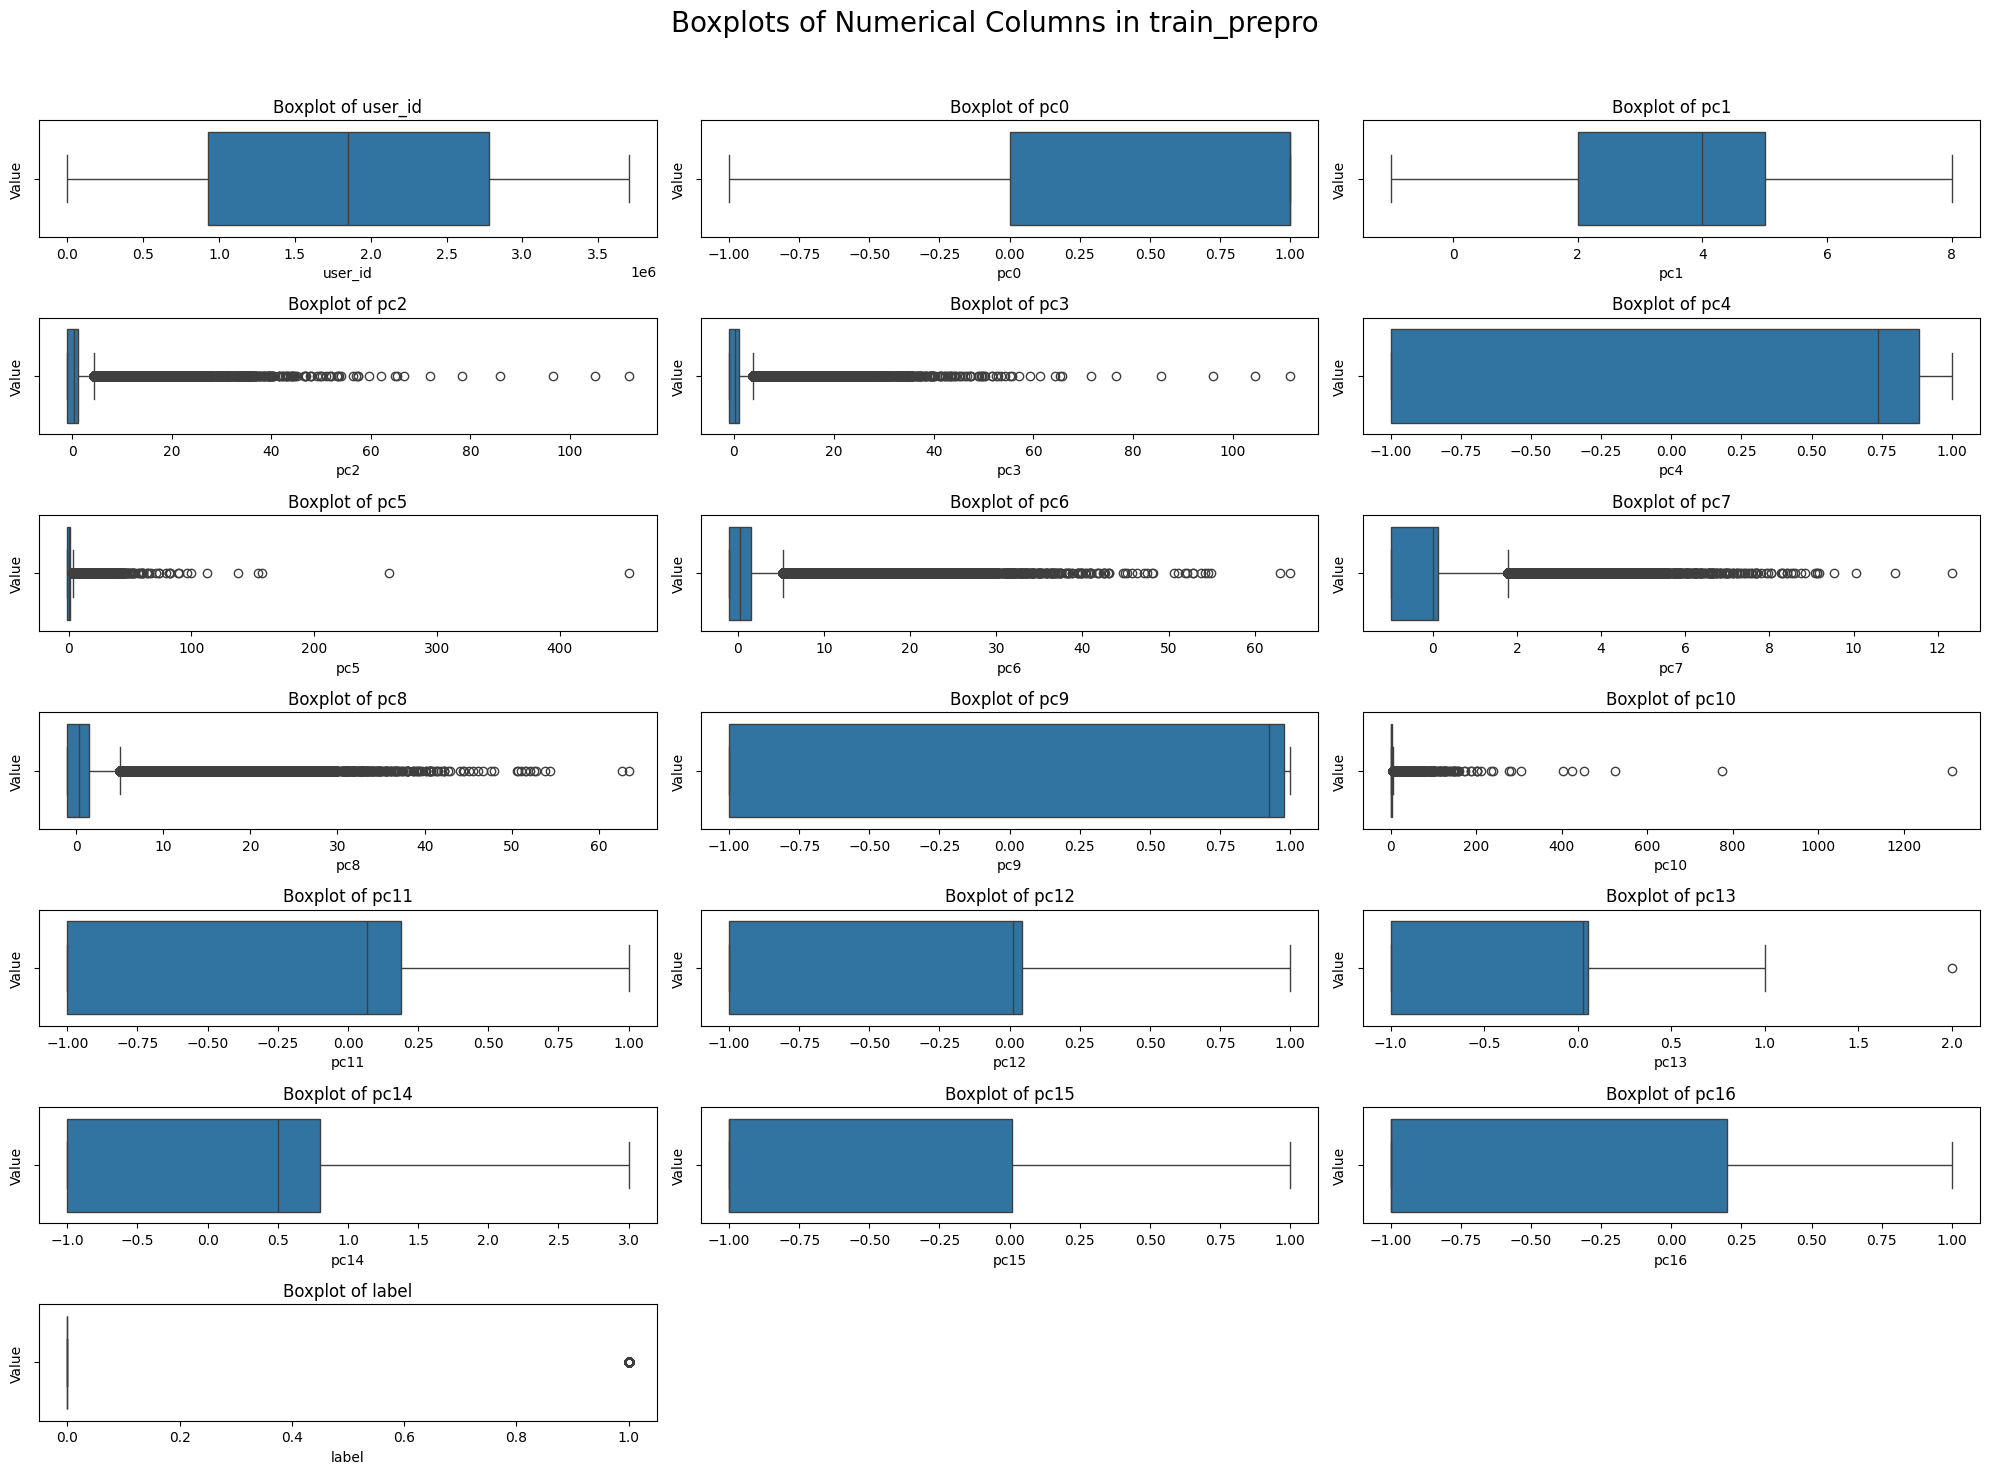

In [123]:
def plot_boxplots(df, title):
    num_cols = df.select_dtypes(include='number').columns 
    plt.figure(figsize=(20, 15))  # Adjust figure size as needed

    for i, col in enumerate(num_cols):
        plt.subplot(len(num_cols) // 3 + 1, 3, i + 1)
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col}')
        plt.xlabel(col)
        plt.ylabel('Value')

    plt.suptitle(title, fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_boxplots(train_prepro, 'Boxplots of train_prepro')

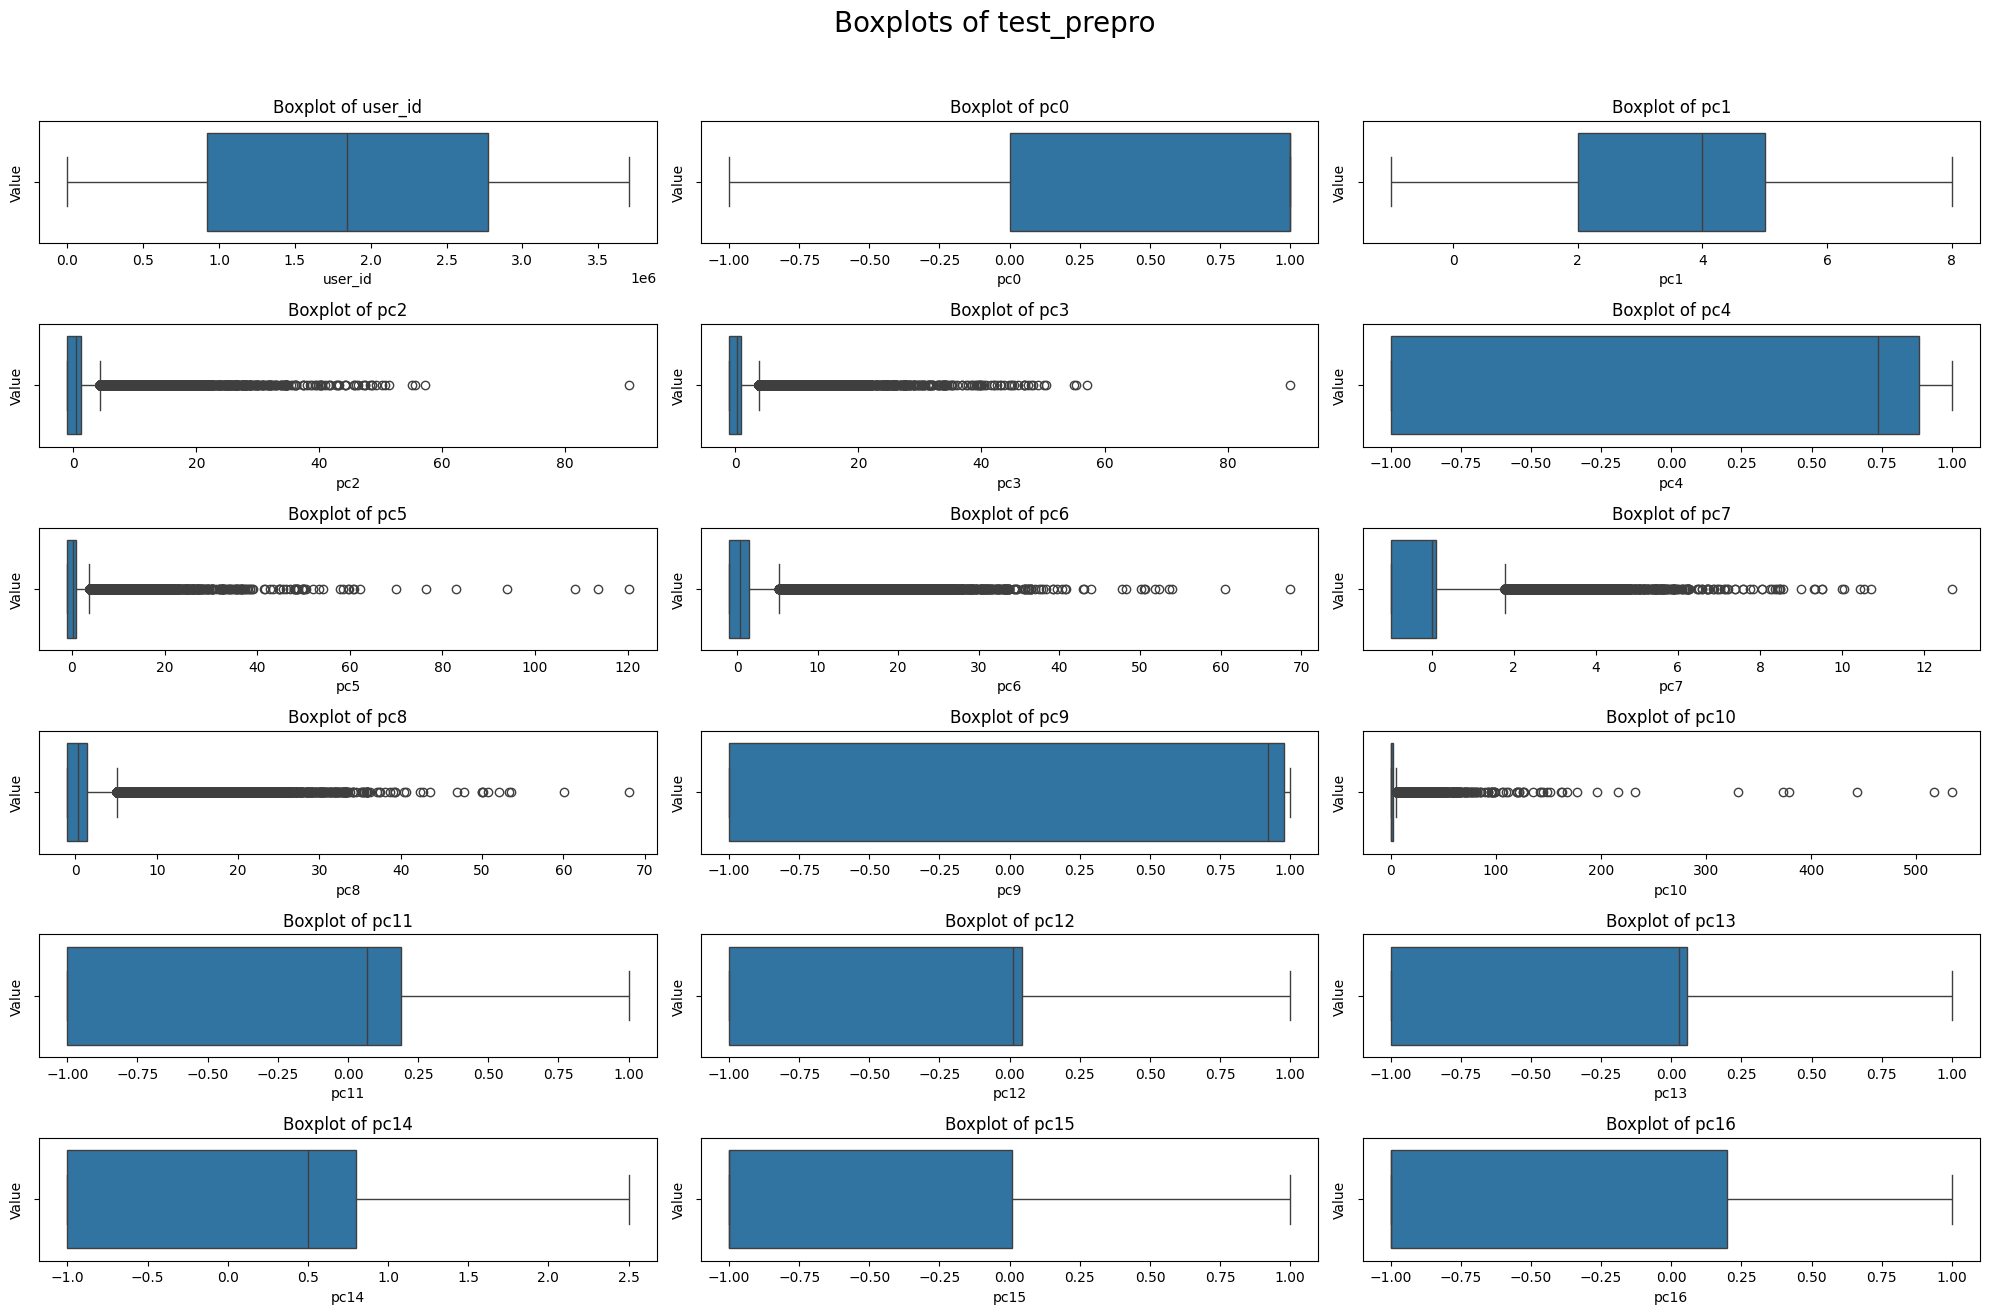

In [124]:
plot_boxplots(test_prepro, 'Boxplots of test_prepro')

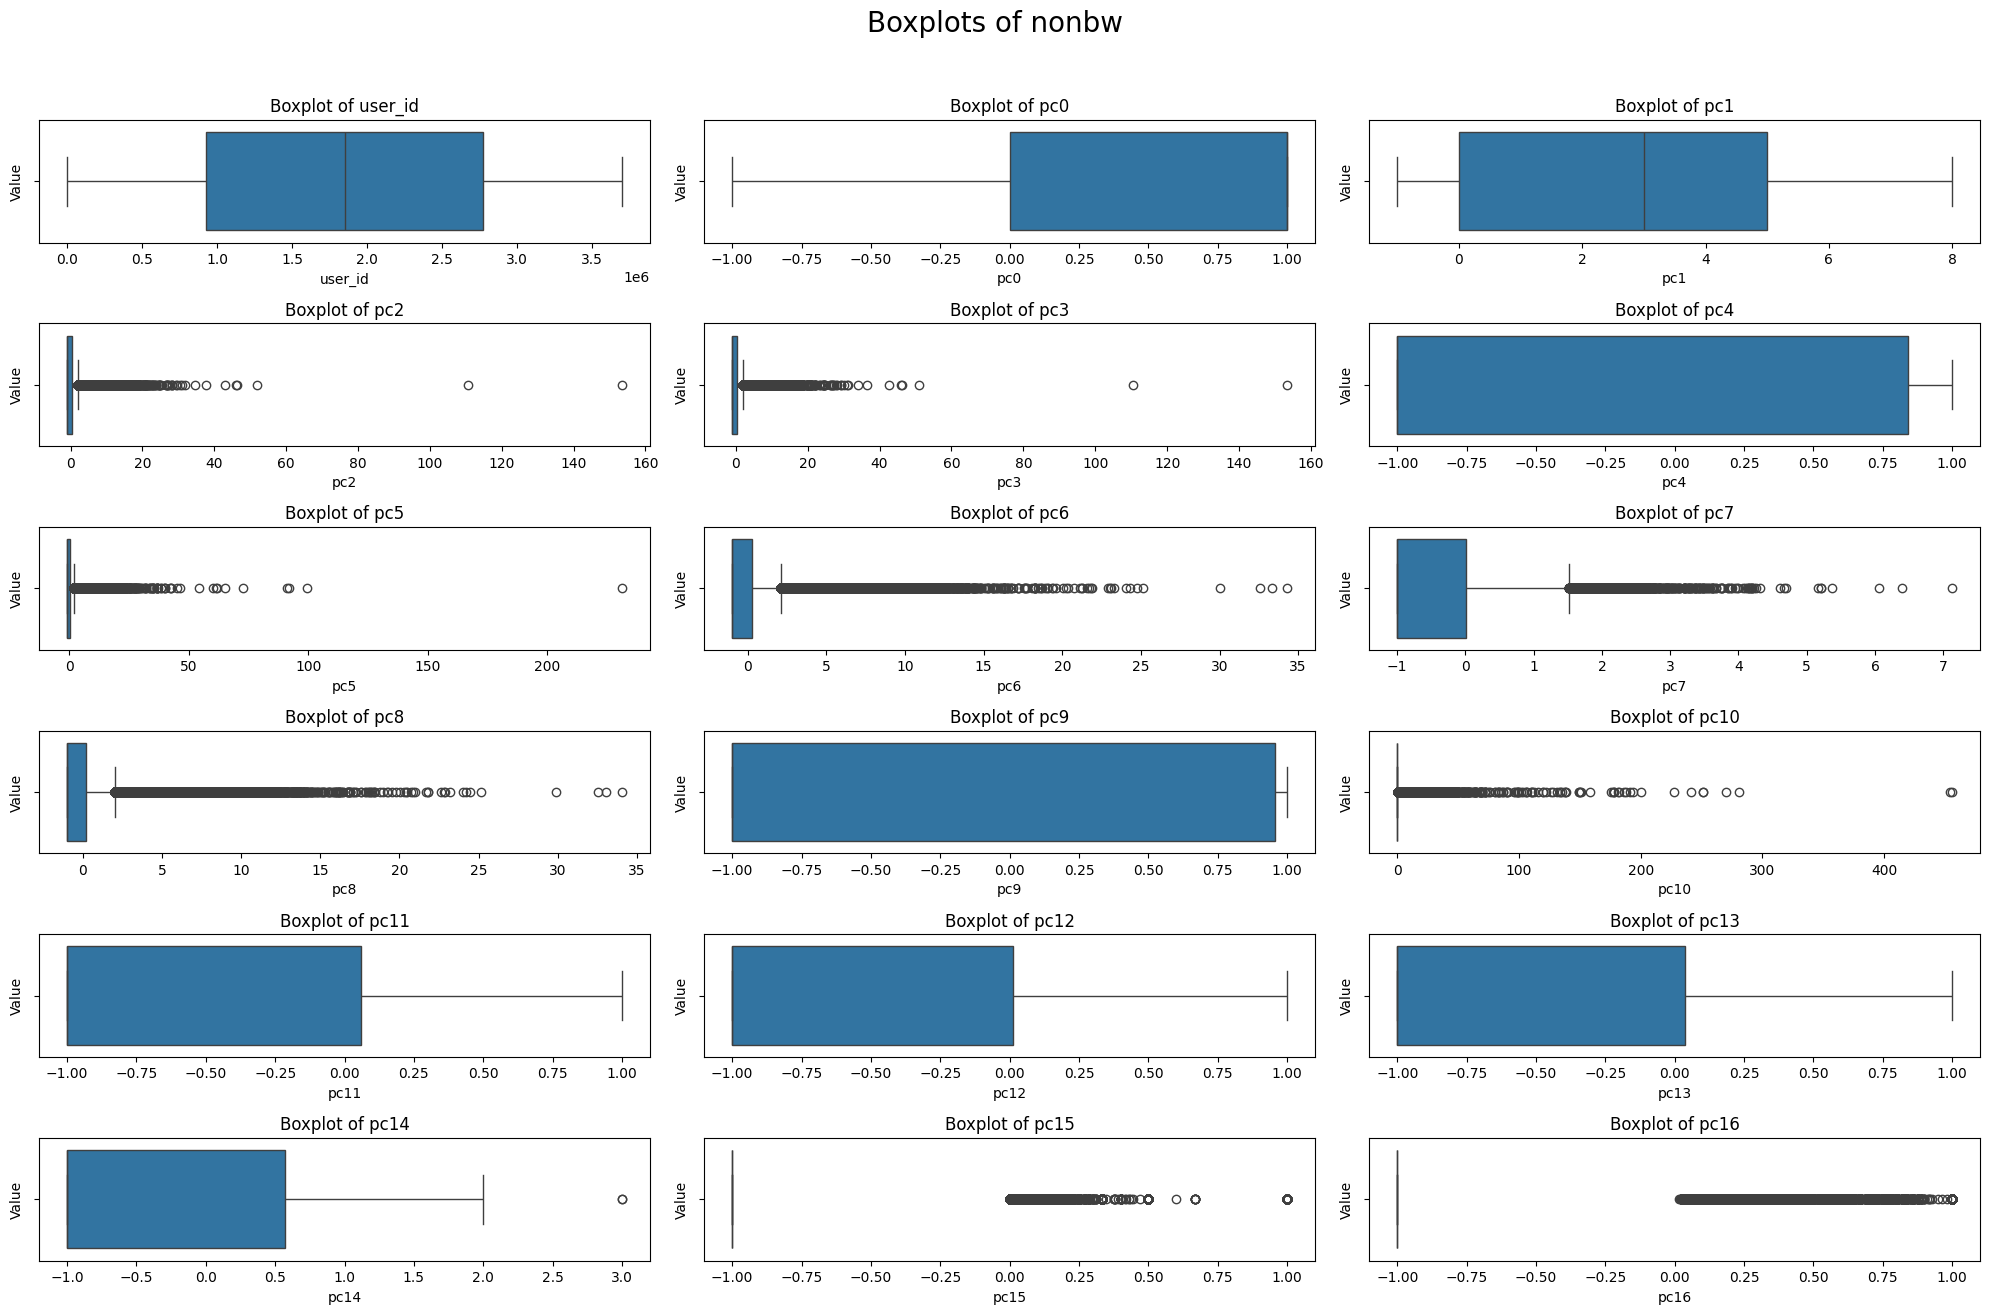

In [125]:
plot_boxplots(nonbw, 'Boxplots of nonbw')

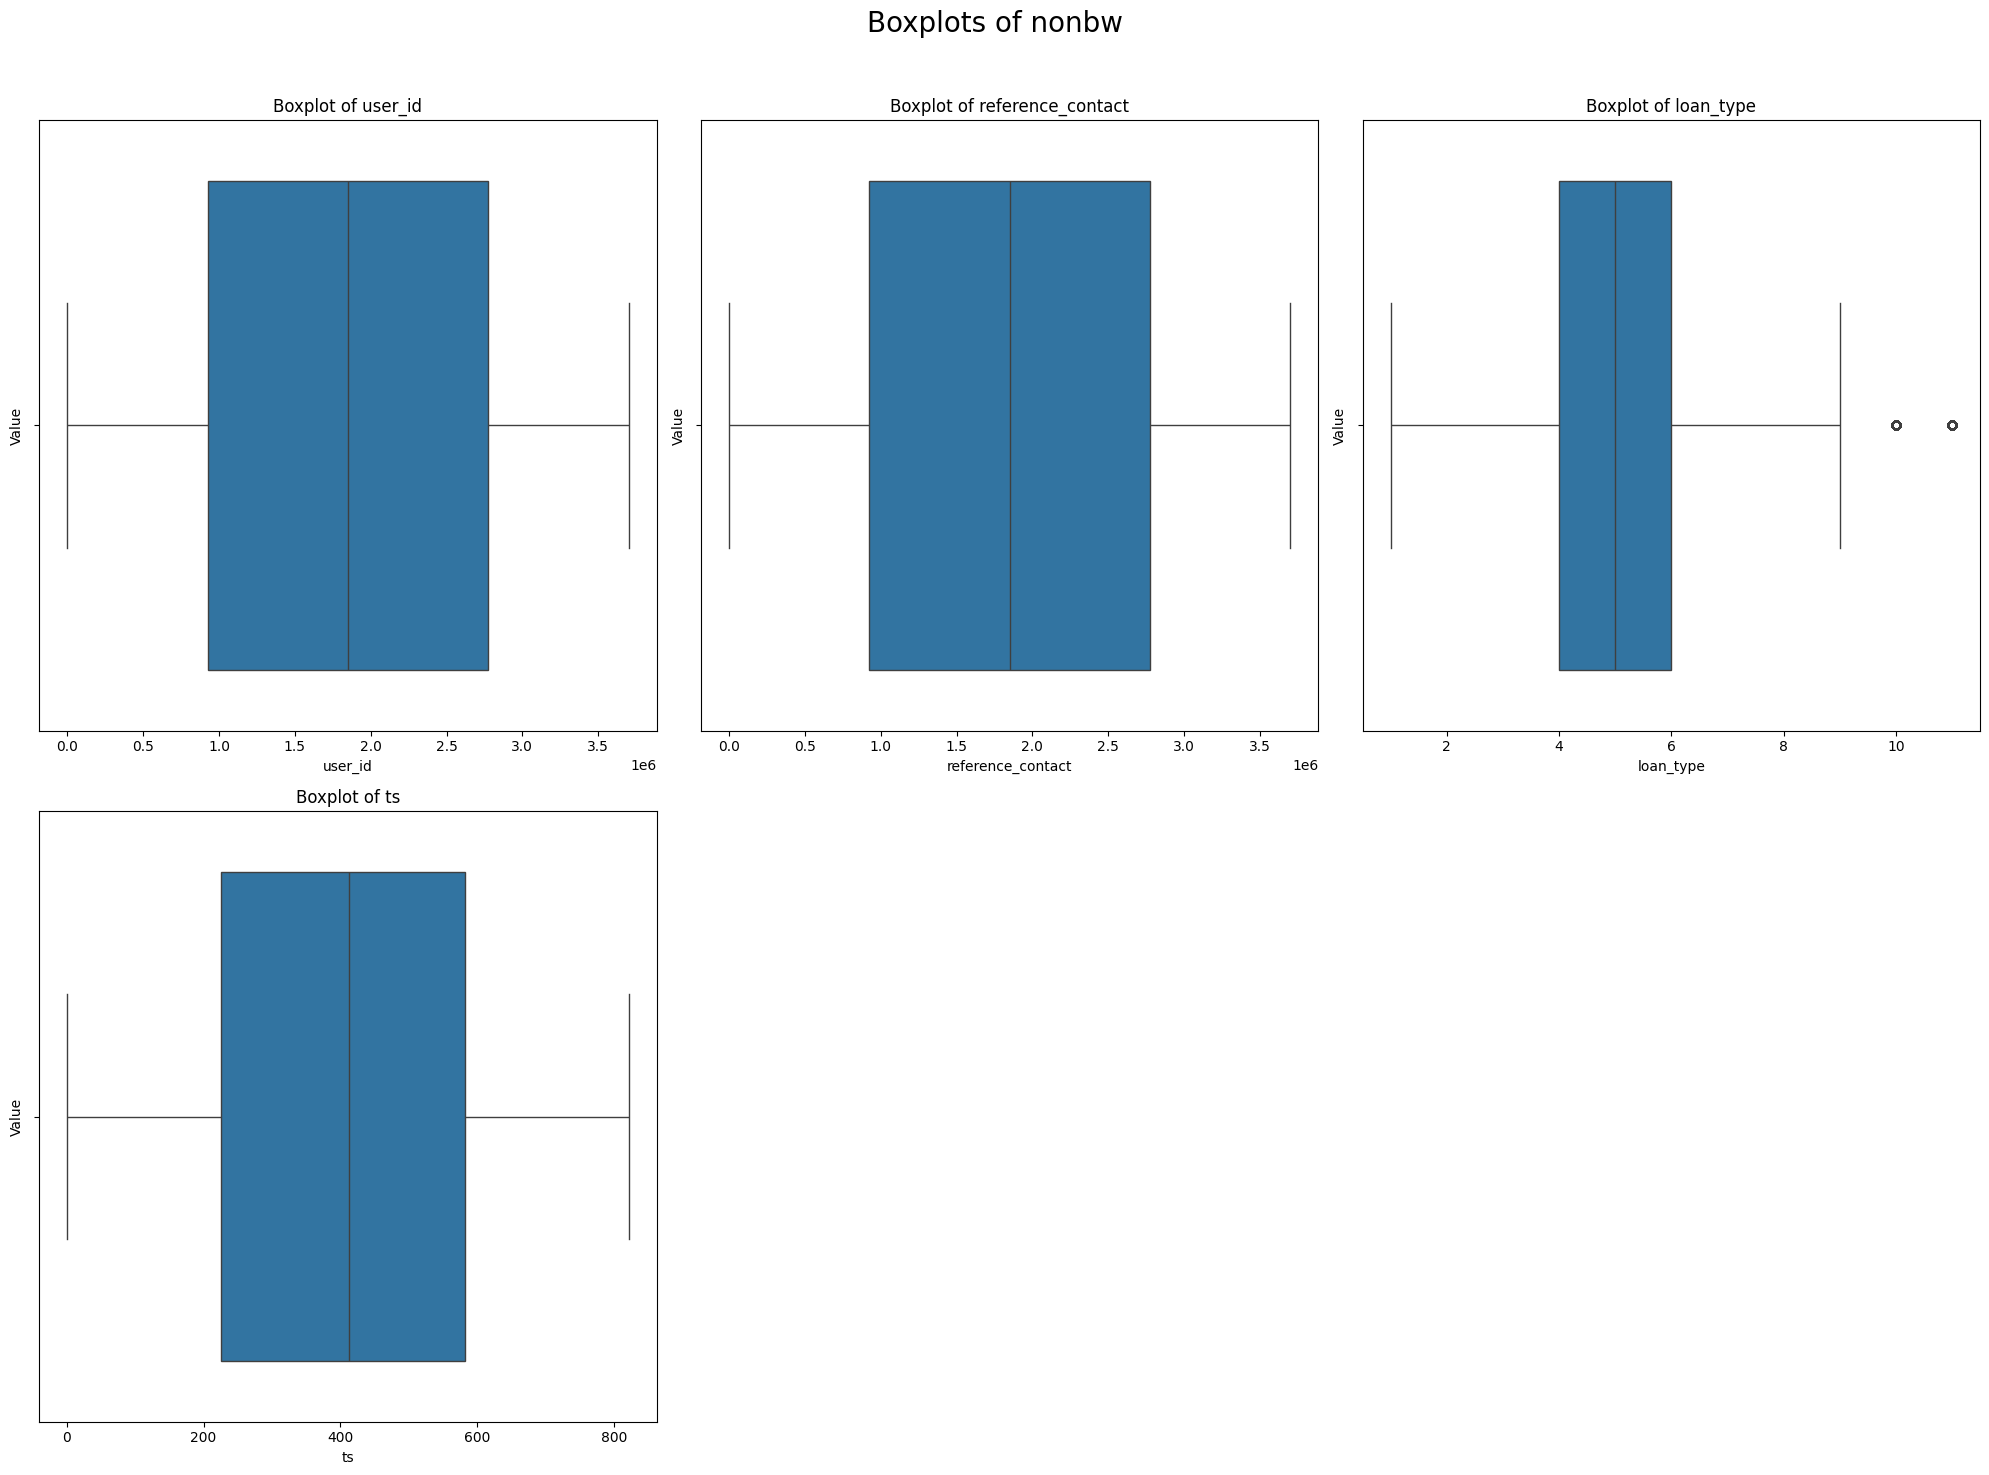

In [14]:
plot_boxplots(loan, 'Boxplots of nonbw')

Terlihat beberapa variabel dengan outliers, ini dapat menjadi acuan untuk metode scaling yang akan digunakan nantinya

## FEATURE ENGINEERING

Beberapa hal yang dilakukan:
* Membuat variabel referenced_in_loan dengan nilai 1 apabila user_id pernah muncul pada kolom "reference_contact" pada dataset loan dan 0 apabila tidak
* Membuat variabel	referencing_non_bw dengan nilai 1 apabila user_id pernah mengisi user_id dari dataset nonborrower pada reference_contact di dataset loan dan 0 apabila tidak
* Aggregating Features: Melakukan agregasi dari beberapa data dengan user_id yang sama, kemudian dilakukan perhitungan statistika deskriptif

** Scaling tidak jadi  dilakukan karena model gradient boosting, seperti CatBoost, XGBoost, dan LGBM performanya tidak terlalu berpengaruh apabila variabel discaling/tidak **

In [3]:
#reference_in_loan
train_prepro['referenced_in_loan'] = train_prepro['user_id'].isin(loan['reference_contact'].unique()).astype(int)
test_prepro['referenced_in_loan'] = test_prepro['user_id'].isin(loan['reference_contact'].unique()).astype(int)


#referencing_non_bw
filtered_loan_train = loan[loan['user_id'].isin(train_prepro['user_id'])]
result = filtered_loan_train[filtered_loan_train['reference_contact'].isin(nonbw['user_id'])]

train_prepro['referencing_non_bw'] = train_prepro['user_id'].isin(result['user_id']).astype(int)
test_prepro['referencing_non_bw'] = test_prepro['user_id'].isin(result['user_id']).astype(int)
train_prepro

,user_id,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,label,referenced_in_loan,referencing_non_bw
0,3,1.0,1.0,0.275,0.255,0.927273,0.4,0.260,0.040,0.254,0.976923,1.0,0.072727,0.023077,0.078431,0.750000,0.018182,0.250000,0,1,0
1,5,0.0,0.0,0.430,0.365,0.848837,0.4,1.253,0.210,1.235,0.985634,1.0,0.151163,0.014366,0.054795,0.500000,0.011628,0.250000,0,1,1
2,9,1.0,3.0,1.315,0.825,0.627376,0.9,2.385,0.128,2.270,0.951782,1.0,0.372624,0.048218,0.054545,0.777778,0.003802,0.111111,0,1,1
3,10,0.0,5.0,-1.000,-1.000,-1.000000,-1.0,-1.000,-1.000,-1.000,-1.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0,1,1
4,17,1.0,1.0,0.235,0.160,0.680851,0.1,0.120,0.002,0.104,0.866667,0.0,0.319149,0.133333,0.031250,-1.000000,-1.000000,-1.000000,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857894,3700529,1.0,4.0,0.190,0.160,0.842105,0.1,0.281,0.005,0.274,0.975089,0.0,0.157895,0.024911,0.031250,1.000000,-1.000000,-1.000000,0,1,0
857895,3700532,1.0,3.0,1.710,1.535,0.897661,2.1,3.750,0.687,3.712,0.989867,4.0,0.102339,0.010133,0.068404,0.857143,0.011696,0.190476,0,0,1
857896,3700537,1.0,0.0,2.165,2.060,0.951501,2.4,2.213,0.065,2.186,0.987799,2.0,0.048499,0.012201,0.058252,0.458333,0.004619,0.083333,0,1,1
857897,3700543,1.0,5.0,2.075,1.565,0.754217,1.9,3.292,0.342,3.188,0.968408,4.0,0.245783,0.031592,0.060703,0.736842,0.009639,0.210526,0,0,0


### Aggregating Features

In [4]:
# Membuat aggregated features untuk user-user id yang menjadi reference_contact dari user_id dataset train dan test pada dataset loan

#menggabungkan dataset train dan nonborrower (karena user_id nonbw juga ada yang menjadi reference contact pada dataset loan)
concatenated_df = pd.concat([train, nonbw],ignore_index=True)
merged_loan_concat = loan.merge(concatenated_df, left_on='user_id', right_on='user_id', how='inner')

## untuk variabel numerik akan dilihat min,max,mean,first,last,sum,dan mediannya
## untuk variabel kategorik akan dilihat count,min,max,first,last,dan nunique (variabel diasumsikan kategorik apabila nuniquenya sangat sedikit)
aggregation_pc = {
    'pc0': ['count', 'min','max','first','last','nunique'], 
    'pc1': ['count','min','max','first','last','nunique'],
    'pc2': ['min', 'max', 'mean','first','last', 'sum', 'median'],
    'pc3': ['min', 'max', 'mean', 'first','last','sum', 'median'],
    'pc4': ['min', 'max', 'mean','first','last', 'sum', 'median'],
    'pc5': ['min', 'max', 'mean','first','last', 'sum', 'median'],
    'pc6': ['min', 'max', 'mean','first','last', 'sum', 'median'],
    'pc7': ['min', 'max', 'mean','first','last', 'sum', 'median'],
    'pc8': ['min', 'max', 'mean','first','last', 'sum', 'median'],
    'pc9': ['min', 'max', 'mean','first','last', 'sum', 'median'],
    'pc10': ['min', 'max', 'mean','first','last', 'sum', 'median'],
    'pc11': ['min', 'max', 'mean','first','last', 'sum', 'median'],
    'pc12': ['min', 'max', 'mean','first','last', 'sum', 'median'],
    'pc13': ['min', 'max', 'mean','first','last', 'sum', 'median'],
    'pc14': ['min', 'max', 'mean','first','last', 'sum', 'median'],
    'pc15': ['min', 'max', 'mean','first','last', 'sum', 'median'],
    'pc16': ['min', 'max', 'mean','first','last', 'sum', 'median']
}

merged_loan_concat = loan.merge(concatenated_df, left_on='reference_contact', right_on='user_id', how='inner')
loan_agg = merged_loan_concat.groupby('user_id_x').agg(aggregation_pc).reset_index()
loan_agg.columns = ['ref_'.join(col).strip() if col[1] else col[0] for col in loan_agg.columns.values]



train_prepro = train_prepro.merge(loan_agg, left_on='user_id', right_on='user_id_x', how='left')
test_prepro = test_prepro.merge(loan_agg, left_on='user_id', right_on='user_id_x', how='left')

drop_id = loan_agg.columns.drop(['user_id_x']) 
train_prepro[drop_id] = train_prepro[drop_id].fillna(-1) #replace missing values dengan -1
test_prepro[drop_id] = test_prepro[drop_id].fillna(-1)


train_prepro.drop(columns=['user_id_x'], axis=1, inplace=True)
test_prepro.drop(columns=['user_id_x'], axis=1, inplace=True)

train_prepro

,user_id,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,label,referenced_in_loan,referencing_non_bw,pc0ref_count,pc0ref_min,pc0ref_max,pc0ref_first,pc0ref_last,pc0ref_nunique,pc1ref_count,pc1ref_min,pc1ref_max,pc1ref_first,pc1ref_last,pc1ref_nunique,pc2ref_min,pc2ref_max,pc2ref_mean,pc2ref_first,pc2ref_last,pc2ref_sum,pc2ref_median,pc3ref_min,pc3ref_max,pc3ref_mean,pc3ref_first,pc3ref_last,pc3ref_sum,pc3ref_median,pc4ref_min,pc4ref_max,pc4ref_mean,pc4ref_first,pc4ref_last,pc4ref_sum,pc4ref_median,pc5ref_min,pc5ref_max,pc5ref_mean,pc5ref_first,pc5ref_last,pc5ref_sum,pc5ref_median,pc6ref_min,pc6ref_max,pc6ref_mean,pc6ref_first,pc6ref_last,pc6ref_sum,pc6ref_median,pc7ref_min,pc7ref_max,pc7ref_mean,pc7ref_first,pc7ref_last,pc7ref_sum,pc7ref_median,pc8ref_min,pc8ref_max,pc8ref_mean,pc8ref_first,pc8ref_last,pc8ref_sum,pc8ref_median,pc9ref_min,pc9ref_max,pc9ref_mean,pc9ref_first,pc9ref_last,pc9ref_sum,pc9ref_median,pc10ref_min,pc10ref_max,pc10ref_mean,pc10ref_first,pc10ref_last,pc10ref_sum,pc10ref_median,pc11ref_min,pc11ref_max,pc11ref_mean,pc11ref_first,pc11ref_last,pc11ref_sum,pc11ref_median,pc12ref_min,pc12ref_max,pc12ref_mean,pc12ref_first,pc12ref_last,pc12ref_sum,pc12ref_median,pc13ref_min,pc13ref_max,pc13ref_mean,pc13ref_first,pc13ref_last,pc13ref_sum,pc13ref_median,pc14ref_min,pc14ref_max,pc14ref_mean,pc14ref_first,pc14ref_last,pc14ref_sum,pc14ref_median,pc15ref_min,pc15ref_max,pc15ref_mean,pc15ref_first,pc15ref_last,pc15ref_sum,pc15ref_median,pc16ref_min,pc16ref_max,pc16ref_mean,pc16ref_first,pc16ref_last,pc16ref_sum,pc16ref_median
0,3,1.0,1.0,0.275,0.255,0.927273,0.4,0.260,0.040,0.254,0.976923,1.0,0.072727,0.023077,0.078431,0.750000,0.018182,0.250000,0,1,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1,5,0.0,0.0,0.430,0.365,0.848837,0.4,1.253,0.210,1.235,0.985634,1.0,0.151163,0.014366,0.054795,0.500000,0.011628,0.250000,0,1,1,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,4.0,1.0,4.0,2.0,-1.000,-1.000,-1.000000,-1.000,-1.000,-2.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-2.000,-1.000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-2.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-2.0,-1.0,-1.000,-1.000,-1.000000,-1.000,-1.000,-2.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-2.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-2.000,-1.000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-2.000000,-1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-2.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-2.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-2.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-2.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-2.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-2.000000,-1.000000
2,9,1.0,3.0,1.315,0.825,0.627376,0.9,2.385,0.128,2.270,0.951782,1.0,0.372624,0.048218,0.054545,0.777778,0.003802,0.111111,0,1,1,3.0,-1.0,1.0,1.0,-1.0,2.0,3.0,-1.0,3.0,2.0,-1.0,3.0,-1.000,-1.000,-1.000000,-1.000,-1.000,-3.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-3.000,-1.000,-1.000000,-1.

In [5]:
# Membuat aggregated features untuk variabel-variabel loan dari user_id dataset train dan test.

loan2 = loan.copy()


cat_features = ['reference_contact', 'ts', 'loan_type'] #semua variabel loan kategorik
loan_agg = loan2.groupby('user_id')[cat_features].agg(['count', 'min','max','first','last','nunique']).reset_index() ## untuk variabel kategorik akan dilihat count,first,last,dan nunique

loan_agg.columns = ['_'.join(col).strip() if col[1] else col[0] for col in loan_agg.columns.values]
loan_agg = loan_agg.fillna(-1).astype(int) #replace NA dengan -1

#merge ke dataset train dan test
train_prepro = train_prepro.merge(loan_agg, on='user_id', how='left')
test_prepro = test_prepro.merge(loan_agg, on='user_id', how='left')

train_prepro.fillna(value=-1, inplace=True)#replace NA dengan -1
test_prepro.fillna(value=-1, inplace=True)

# Print the resulting train_prepro
train_prepro

,user_id,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,label,referenced_in_loan,referencing_non_bw,pc0ref_count,pc0ref_min,pc0ref_max,pc0ref_first,pc0ref_last,pc0ref_nunique,pc1ref_count,pc1ref_min,pc1ref_max,pc1ref_first,pc1ref_last,pc1ref_nunique,pc2ref_min,pc2ref_max,pc2ref_mean,pc2ref_first,pc2ref_last,pc2ref_sum,pc2ref_median,pc3ref_min,pc3ref_max,pc3ref_mean,pc3ref_first,pc3ref_last,pc3ref_sum,pc3ref_median,pc4ref_min,pc4ref_max,pc4ref_mean,pc4ref_first,pc4ref_last,pc4ref_sum,pc4ref_median,pc5ref_min,pc5ref_max,pc5ref_mean,pc5ref_first,pc5ref_last,pc5ref_sum,pc5ref_median,pc6ref_min,pc6ref_max,pc6ref_mean,pc6ref_first,pc6ref_last,pc6ref_sum,pc6ref_median,pc7ref_min,pc7ref_max,pc7ref_mean,pc7ref_first,pc7ref_last,pc7ref_sum,pc7ref_median,pc8ref_min,pc8ref_max,pc8ref_mean,pc8ref_first,pc8ref_last,pc8ref_sum,pc8ref_median,pc9ref_min,pc9ref_max,pc9ref_mean,pc9ref_first,pc9ref_last,pc9ref_sum,pc9ref_median,pc10ref_min,pc10ref_max,pc10ref_mean,pc10ref_first,pc10ref_last,pc10ref_sum,pc10ref_median,pc11ref_min,pc11ref_max,pc11ref_mean,pc11ref_first,pc11ref_last,pc11ref_sum,pc11ref_median,pc12ref_min,pc12ref_max,pc12ref_mean,pc12ref_first,pc12ref_last,pc12ref_sum,pc12ref_median,pc13ref_min,pc13ref_max,pc13ref_mean,pc13ref_first,pc13ref_last,pc13ref_sum,pc13ref_median,pc14ref_min,pc14ref_max,pc14ref_mean,pc14ref_first,pc14ref_last,pc14ref_sum,pc14ref_median,pc15ref_min,pc15ref_max,pc15ref_mean,pc15ref_first,pc15ref_last,pc15ref_sum,pc15ref_median,pc16ref_min,pc16ref_max,pc16ref_mean,pc16ref_first,pc16ref_last,pc16ref_sum,pc16ref_median,reference_contact_count,reference_contact_min,reference_contact_max,reference_contact_first,reference_contact_last,reference_contact_nunique,ts_count,ts_min,ts_max,ts_first,ts_last,ts_nunique,loan_type_count,loan_type_min,loan_type_max,loan_type_first,loan_type_last,loan_type_nunique
0,3,1.0,1.0,0.275,0.255,0.927273,0.4,0.260,0.040,0.254,0.976923,1.0,0.072727,0.023077,0.078431,0.750000,0.018182,0.250000,0,1,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,5,0.0,0.0,0.430,0.365,0.848837,0.4,1.253,0.210,1.235,0.985634,1.0,0.151163,0.014366,0.054795,0.500000,0.011628,0.250000,0,1,1,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,4.0,1.0,4.0,2.0,-1.000,-1.000,-1.000000,-1.000,-1.000,-2.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-2.000,-1.000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-2.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-2.0,-1.0,-1.000,-1.000,-1.000000,-1.000,-1.000,-2.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-2.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-2.000,-1.000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-2.000000,-1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-2.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-2.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-2.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-2.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-2.000000

## MODELLING

### Splitting the Dataset

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import optuna
X=train_prepro.drop(columns=['label','user_id'])
y=train_prepro['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Choosing the Best Model

* Hanya akan dicoba 3 model, yaitu XGBoost, CatBoost, dan LightGBM sebab sering kali ketiga model ini memberikan hasil prediksi yang sangat baik dibanding model-model lainnya
* Akan dilakukan resampling karena variabel target (label) imbalanced

#### XGBOOST

In [7]:
#Karena variabel target (label) sangat imbalanced akan dilakukan resampling -- oversampling menggunakan SMOTE memberikan akurasi yang lebih kecil
#sampling_strategy dipilih berdasarkan hasil percobaan dari range 0.1 - 1
undersample = RandomUnderSampler(sampling_strategy=0.1, random_state=42)
X_resampled, y_resampled = undersample.fit_resample(X_train, y_train)

oversample = RandomOverSampler(sampling_strategy=1, random_state=42)
X_resampled1, y_resampled1 = oversample.fit_resample(X_resampled, y_resampled)


model_xgb = XGBClassifier(random_state=42)
model_xgb.fit(X_resampled1, y_resampled1)

y_pred = model_xgb.predict_proba(X_test)[:, 1]


print(f"Accuracy: {average_precision_score(y_test, y_pred)}")


y_class=model_xgb.predict(X_test)
print(classification_report(y_test, y_class))

Accuracy: 0.04433715089181466
              precision    recall  f1-score   support

           0       1.00      0.75      0.85    169409
           1       0.04      0.72      0.07      2171

    accuracy                           0.75    171580
   macro avg       0.52      0.73      0.46    171580
weighted avg       0.98      0.75      0.84    171580



#### LGBM

In [8]:
#Karena variabel target (label) sangat imbalanced akan dilakukan resampling -- oversampling menggunakan SMOTE memberikan akurasi yang lebih kecil
#sampling_strategy dipilih berdasarkan hasil percobaan dari range 0.1 - 1

undersample = RandomUnderSampler(sampling_strategy=0.1, random_state=42)
X_resampled, y_resampled = undersample.fit_resample(X_train, y_train)

oversample = RandomOverSampler(sampling_strategy=1, random_state=42)
X_resampled1, y_resampled1 = oversample.fit_resample(X_resampled, y_resampled)

model_lgb = LGBMClassifier(random_state=42)
model_lgb.fit(X_resampled1, y_resampled1)
y_pred = model_lgb.predict_proba(X_test)[:, 1]


print(f"Accuracy: {average_precision_score(y_test, y_pred)}")

y_class=model_lgb.predict(X_test)
print(classification_report(y_test, y_class))

[LightGBM] [Info] Number of positive: 86860, number of negative: 86860
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29683
[LightGBM] [Info] Number of data points in the train set: 173720, number of used features: 154
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy: 0.048019891174003425
              precision    recall  f1-score   support

           0       1.00      0.72      0.83    169409
           1       0.03      0.79      0.07      2171

    accuracy                           0.72    171580
   macro avg       0.52      0.75      0.45    171580
weighted avg       0.98      0.72      0.82    171580



#### CatBoost

In [9]:
#Karena variabel target (label) sangat imbalanced akan dilakukan resampling -- oversampling menggunakan SMOTE memberikan akurasi yang lebih kecil
#sampling_strategy dipilih berdasarkan hasil percobaan dari range 0.1 - 1
undersample = RandomUnderSampler(sampling_strategy=0.1,random_state=42)
X_resampled, y_resampled = undersample.fit_resample(X_train, y_train)

oversample = RandomOverSampler(sampling_strategy=0.15, random_state=42)
X_resampled1, y_resampled1 = oversample.fit_resample(X_resampled, y_resampled)

model_cb = CatBoostClassifier(random_state=42,verbose=0)
model_cb.fit(X_resampled1, y_resampled1)


y_pred = model_cb.predict_proba(X_test)[:, 1]


print(f"Accuracy: {average_precision_score(y_test, y_pred)}")

y_class=model_cb.predict(X_test)
print(classification_report(y_test, y_class))

Accuracy: 0.05074152874653512
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    169409
           1       0.10      0.05      0.07      2171

    accuracy                           0.98    171580
   macro avg       0.54      0.52      0.53    171580
weighted avg       0.98      0.98      0.98    171580



### Hyperparameter Tuning with Optuna

In [13]:
def objective(trial):
    params = {
        'iterations':trial.suggest_int('iterations',300,1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 20),
        'random_state': 42,
        'verbose': False
    }


    model = CatBoostClassifier(**params)
    model.fit(X_resampled1, y_resampled1, verbose_eval=False)

    y_pred = model.predict_proba(X_test)[:, 1]
    avg_precision = average_precision_score(y_test, y_pred)

    return avg_precision

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

best_trial = study.best_trial
print(f'Best trial - Average Precision: {best_trial.value:.4f}')
print(f'Best parameters: {best_trial.params}')

[I 2024-07-14 17:48:46,566] A new study created in memory with name: no-name-989f229c-e773-48ae-b1f4-2873d5f79a6d
[I 2024-07-14 17:48:50,746] Trial 0 finished with value: 0.03828129657426121 and parameters: {'iterations': 409, 'learning_rate': 0.005808018660043397, 'max_depth': 2, 'subsample': 0.5988255028580336, 'colsample_bylevel': 0.7197238055568045, 'min_child_samples': 4}. Best is trial 0 with value: 0.03828129657426121.
[I 2024-07-14 17:49:00,516] Trial 1 finished with value: 0.04568900508479075 and parameters: {'iterations': 565, 'learning_rate': 0.01456949113649272, 'max_depth': 5, 'subsample': 0.7920679221108831, 'colsample_bylevel': 0.27315927911392185, 'min_child_samples': 15}. Best is trial 1 with value: 0.04568900508479075.
[I 2024-07-14 17:49:03,577] Trial 2 finished with value: 0.04484300961728491 and parameters: {'iterations': 367, 'learning_rate': 0.057827698878087475, 'max_depth': 2, 'subsample': 0.291295796827153, 'colsample_bylevel': 0.550300857760816, 'min_child_sa

[I 2024-07-14 18:04:09,270] Trial 26 finished with value: 0.04656045868182439 and parameters: {'iterations': 909, 'learning_rate': 0.010470038557360655, 'max_depth': 5, 'subsample': 0.7248294055532112, 'colsample_bylevel': 0.6009588379984866, 'min_child_samples': 6}. Best is trial 14 with value: 0.050166135301181615.
[I 2024-07-14 18:04:46,332] Trial 27 finished with value: 0.04652404024287496 and parameters: {'iterations': 632, 'learning_rate': 0.007387680124805026, 'max_depth': 8, 'subsample': 0.45419078673927454, 'colsample_bylevel': 0.8851115851278234, 'min_child_samples': 13}. Best is trial 14 with value: 0.050166135301181615.
[I 2024-07-14 18:04:56,365] Trial 28 finished with value: 0.0452730649042963 and parameters: {'iterations': 763, 'learning_rate': 0.019143457362398576, 'max_depth': 4, 'subsample': 0.10722677356573501, 'colsample_bylevel': 0.6890442814744503, 'min_child_samples': 16}. Best is trial 14 with value: 0.050166135301181615.
[I 2024-07-14 18:05:02,232] Trial 29 fin

[I 2024-07-14 18:18:41,296] Trial 52 finished with value: 0.05059314226737145 and parameters: {'iterations': 728, 'learning_rate': 0.06706046817356683, 'max_depth': 5, 'subsample': 0.771286619104552, 'colsample_bylevel': 0.4162783337221015, 'min_child_samples': 16}. Best is trial 43 with value: 0.050833735100523234.
[I 2024-07-14 18:19:01,313] Trial 53 finished with value: 0.049375627325809496 and parameters: {'iterations': 746, 'learning_rate': 0.030311415484975436, 'max_depth': 5, 'subsample': 0.6899287922895567, 'colsample_bylevel': 0.7164502804285502, 'min_child_samples': 15}. Best is trial 43 with value: 0.050833735100523234.
[I 2024-07-14 18:19:48,687] Trial 54 finished with value: 0.046788673842817055 and parameters: {'iterations': 768, 'learning_rate': 0.07941521989676746, 'max_depth': 8, 'subsample': 0.7665210214737174, 'colsample_bylevel': 0.6678515764585059, 'min_child_samples': 16}. Best is trial 43 with value: 0.050833735100523234.
[I 2024-07-14 18:20:12,546] Trial 55 fini

[I 2024-07-14 18:31:31,234] Trial 78 finished with value: 0.049840909611080245 and parameters: {'iterations': 880, 'learning_rate': 0.024357527016945612, 'max_depth': 7, 'subsample': 0.6916252695383186, 'colsample_bylevel': 0.3656857034033461, 'min_child_samples': 17}. Best is trial 43 with value: 0.050833735100523234.
[I 2024-07-14 18:31:54,577] Trial 79 finished with value: 0.04593465237425416 and parameters: {'iterations': 787, 'learning_rate': 0.008489652767717643, 'max_depth': 5, 'subsample': 0.8296404990474482, 'colsample_bylevel': 0.8193165385826741, 'min_child_samples': 11}. Best is trial 43 with value: 0.050833735100523234.
[I 2024-07-14 18:32:14,992] Trial 80 finished with value: 0.04652529427112418 and parameters: {'iterations': 861, 'learning_rate': 0.014204490792363213, 'max_depth': 4, 'subsample': 0.7408905589646322, 'colsample_bylevel': 0.9131053185045859, 'min_child_samples': 13}. Best is trial 43 with value: 0.050833735100523234.
[I 2024-07-14 18:32:36,799] Trial 81 fi

[I 2024-07-14 18:42:59,263] Trial 104 finished with value: 0.05001071749477726 and parameters: {'iterations': 853, 'learning_rate': 0.03899200184455473, 'max_depth': 6, 'subsample': 0.7688364436359993, 'colsample_bylevel': 0.9637827499083749, 'min_child_samples': 14}. Best is trial 43 with value: 0.050833735100523234.
[I 2024-07-14 18:43:33,695] Trial 105 finished with value: 0.04971770584314061 and parameters: {'iterations': 972, 'learning_rate': 0.03279612817840378, 'max_depth': 6, 'subsample': 0.6824177356605902, 'colsample_bylevel': 0.914783807437301, 'min_child_samples': 16}. Best is trial 43 with value: 0.050833735100523234.
[I 2024-07-14 18:43:58,637] Trial 106 finished with value: 0.04999315491723417 and parameters: {'iterations': 904, 'learning_rate': 0.04861680802435039, 'max_depth': 5, 'subsample': 0.6486652266882087, 'colsample_bylevel': 0.9345907233164367, 'min_child_samples': 13}. Best is trial 43 with value: 0.050833735100523234.
[I 2024-07-14 18:44:31,068] Trial 107 fin

[I 2024-07-14 18:55:18,286] Trial 130 finished with value: 0.04756124548012036 and parameters: {'iterations': 895, 'learning_rate': 0.010738514128635282, 'max_depth': 6, 'subsample': 0.39284941296940523, 'colsample_bylevel': 0.4342253731342819, 'min_child_samples': 19}. Best is trial 43 with value: 0.050833735100523234.
[I 2024-07-14 18:55:51,625] Trial 131 finished with value: 0.04903633609338781 and parameters: {'iterations': 854, 'learning_rate': 0.025052197897277268, 'max_depth': 6, 'subsample': 0.8546734789468232, 'colsample_bylevel': 0.873076747915443, 'min_child_samples': 16}. Best is trial 43 with value: 0.050833735100523234.
[I 2024-07-14 18:56:19,244] Trial 132 finished with value: 0.049535323708154624 and parameters: {'iterations': 871, 'learning_rate': 0.03265544703521442, 'max_depth': 6, 'subsample': 0.7342444522449649, 'colsample_bylevel': 0.44702312626297136, 'min_child_samples': 15}. Best is trial 43 with value: 0.050833735100523234.
[I 2024-07-14 18:56:44,385] Trial 13

[I 2024-07-14 19:12:07,609] Trial 156 finished with value: 0.050328000417205206 and parameters: {'iterations': 878, 'learning_rate': 0.037943611236022995, 'max_depth': 6, 'subsample': 0.9096346301356082, 'colsample_bylevel': 0.9295062542353921, 'min_child_samples': 13}. Best is trial 43 with value: 0.050833735100523234.
[I 2024-07-14 19:12:50,530] Trial 157 finished with value: 0.04757533472361966 and parameters: {'iterations': 877, 'learning_rate': 0.0644950251167249, 'max_depth': 7, 'subsample': 0.8891668098774441, 'colsample_bylevel': 0.9031335382682607, 'min_child_samples': 13}. Best is trial 43 with value: 0.050833735100523234.
[I 2024-07-14 19:13:12,504] Trial 158 finished with value: 0.05026095669638886 and parameters: {'iterations': 949, 'learning_rate': 0.04189353577908961, 'max_depth': 4, 'subsample': 0.9133404600759124, 'colsample_bylevel': 0.9305756529685597, 'min_child_samples': 14}. Best is trial 43 with value: 0.050833735100523234.
[I 2024-07-14 19:13:55,906] Trial 159 f

[I 2024-07-14 19:26:16,437] Trial 182 finished with value: 0.048796936957936056 and parameters: {'iterations': 930, 'learning_rate': 0.027107708876159473, 'max_depth': 7, 'subsample': 0.998170218353885, 'colsample_bylevel': 0.07899349330747157, 'min_child_samples': 18}. Best is trial 163 with value: 0.051378499814991756.
[I 2024-07-14 19:26:45,998] Trial 183 finished with value: 0.05005006980450111 and parameters: {'iterations': 891, 'learning_rate': 0.020190569562520088, 'max_depth': 7, 'subsample': 0.924376179633956, 'colsample_bylevel': 0.2754527767845041, 'min_child_samples': 20}. Best is trial 163 with value: 0.051378499814991756.
[I 2024-07-14 19:27:03,676] Trial 184 finished with value: 0.04921747299152573 and parameters: {'iterations': 903, 'learning_rate': 0.023660510831327006, 'max_depth': 6, 'subsample': 0.9760797154103862, 'colsample_bylevel': 0.10153654676139837, 'min_child_samples': 19}. Best is trial 163 with value: 0.051378499814991756.
[I 2024-07-14 19:27:33,364] Trial

Best trial - Average Precision: 0.0514
Best parameters: {'iterations': 934, 'learning_rate': 0.03393933399782672, 'max_depth': 6, 'subsample': 0.9816052674672805, 'colsample_bylevel': 0.8805759125383187, 'min_child_samples': 15}


In [14]:
#best_params = best_trial.params
best_params =best_trial.params


model_cb = CatBoostClassifier(**best_params,random_state=42,verbose=0)
model_cb.fit(X_resampled1, y_resampled1)


y_pred = model_cb.predict_proba(X_test)[:, 1]


print(f"Accuracy: {average_precision_score(y_test, y_pred)}")

y_class=model_cb.predict(X_test)
print(classification_report(y_test, y_class))

Accuracy: 0.051378499814991756
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    169409
           1       0.11      0.04      0.06      2171

    accuracy                           0.98    171580
   macro avg       0.55      0.52      0.53    171580
weighted avg       0.98      0.98      0.98    171580



In [15]:
### Save Model
model_cb.save_model('catboost_model.json')  

### Load Model
#from_file = CatBoostClassifier()
#from_file.load_model("catboost_model.json")

### Predictions with Actual Dataset

In [18]:
y_test_pred=model_cb.predict_proba(test_prepro)[:, 1]

### Saving the Output

In [21]:
output = pd.DataFrame({'user_id': test.user_id, 'label': y_test_pred})
output.to_csv('submissionfixya.csv', index=False) #tentuin bebas nama filenya
print("Submission Berhasil Tersimpan")

Submission Berhasil Tersimpan


## HASIL DAN KESIMPULAN

Dari hasil analisis di atas, didapatkan model terbaik untuk memprediksi apakah seseorang melakukan penipuan pinjaman uang atau tidak adalah Kfold CatBoost dengan nilai average precision score sebesar 0.05188.